# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Utilities functions

In [2]:
# function plot show missing values
def missing_values_plot(df):
    plt.figure(figsize=(20, 10))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Missing values in the dataset')
    plt.show()

In [3]:
# function plot and show distribution of the target variable
def target_variable_distribution_plot(df, target):
    raw_data = df[target]
    
    # Skip NaNs for plotting and fitting only (non-destructive)
    data_for_plot = raw_data[np.isfinite(raw_data)]

    # show skewness
    skewness = data_for_plot.skew()

    if data_for_plot.empty:
        print(f"Skipping '{target}' — no valid data to plot.")
        return

    plt.figure(figsize=(20, 10))

    # KDE plot
    sns.kdeplot(data_for_plot, bw_adjust=1, label='KDE', fill=True, alpha=0.4)

    # Normal fit
    mu, std = norm.fit(data_for_plot)
    x = np.linspace(data_for_plot.min(), data_for_plot.max(), 1000)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', linewidth=2, label=f'Normal Fit: μ={mu:.2f}, σ={std:.2f}')

    plt.title(f'Distribution of {target} (NaNs not dropped, just ignored for plotting)')
    plt.legend()
    plt.text(0.05, 0.95, f'Skewness: {skewness:.2f}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.grid(True)
    plt.show()

In [4]:
# function check if skewness or not (true or false)
def check_skewness(df, feature):
    skew_val = df[feature].skew()
    if abs(skew_val) > 0.5:
        return True, skew_val
    else:
        return False, skew_val

In [5]:
# function handle missing values with knn imputer
def knn_impute_selected_columns(df, target_column, n_neighbors=5):
    df_imputed = df.copy()
    
    numeric_df = df_imputed.select_dtypes(include='number')

    # Reorder columns to put target column first
    cols = [target_column] + [col for col in numeric_df.columns if col != target_column]
    data_for_impute = numeric_df[cols]

    # Apply KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(data_for_impute)
    imputed_df = pd.DataFrame(imputed_array, columns=cols, index=df.index)

    # Replace only the target column in the original DataFrame
    df_imputed[target_column] = imputed_df[target_column]

    return df_imputed

In [6]:
# function handle missing values with linear regression
def linear_regression_impute(df, target_col):
    df_imputed = df.copy()

    # Select numeric columns
    numeric_cols = df_imputed.select_dtypes(include='number').columns
    if target_col not in numeric_cols:
        print(f"Column '{target_col}' is not numeric or not found.")
        return df_imputed

    # ---------- 1) FILL PREDICTOR MISSING VALUES -------------
    # We fill all numeric columns EXCEPT the target with their medians
    # so we have no NaNs in X.
    for col in numeric_cols:
        if col != target_col:
            median_val = df_imputed[col].median(skipna=True)
            df_imputed.loc[:, col] = df_imputed[col].fillna(median_val)


    # Now build X and y
    X = df_imputed[numeric_cols].drop(columns=[target_col])
    y = df_imputed[target_col]

    # Mask for which rows the target is missing
    missing_mask = y.isna()

    # Training set: target is present
    X_train = X[~missing_mask]
    y_train = y[~missing_mask]

    # Test set: target is missing
    X_test = X[missing_mask]

    # If nothing to train on or nothing to predict, skip
    if X_train.empty or X_test.empty:
        print(f"No training or test data left for '{target_col}'. Skipping.")
        return df_imputed

    # ---------- 2) TRAIN THE MODEL -------------
    model = LinearRegression()
    model.fit(X_train, y_train)

    # ---------- 3) PREDICT MISSING TARGET -------------
    y_pred = model.predict(X_test)

    # Fill the missing target values
    df_imputed.loc[missing_mask, target_col] = y_pred

    return df_imputed

In [7]:
# function handle missing values with MICE-like IterativeImputer
def mice_impute_single_column(
    df,
    target_col,
    random_state=42,
    max_iter=10,
    initial_strategy="mean"
):
    # Copy so we don't modify the original DataFrame
    df_copy = df.copy()

    # Select only numeric columns (including target_col)
    numeric_df = df_copy.select_dtypes(include="number")

    # If target_col is not numeric or doesn't exist, just return the original column
    if target_col not in numeric_df.columns:
        print(f"Skipping '{target_col}' — not numeric or not in DataFrame.")
        return df_copy[target_col]

    # Apply IterativeImputer to *all* numeric columns (including the target_col)
    imputer = IterativeImputer(
        random_state=random_state,
        max_iter=max_iter,
        initial_strategy=initial_strategy
    )
    
    # Fit-transform the numeric DataFrame
    imputed_array = imputer.fit_transform(numeric_df)
    
    # Convert back to DataFrame
    imputed_numeric_df = pd.DataFrame(
        imputed_array, 
        columns=numeric_df.columns,
        index=numeric_df.index
    )
    
    # Return only the column of interest with missing values filled
    return imputed_numeric_df[target_col]

In [8]:
# function plot dendrogram for agglomerative clustering
def plot_dendrogram(X, method='ward', color_threshold=None, country_names=None):
    Z = linkage(X, method=method)
    plt.figure(figsize=(20, 10))
    dendrogram(Z, leaf_rotation=90, color_threshold=color_threshold, labels=country_names)  # leaf_rotation=90 for clearer labels if you have many rows
    plt.title(f"Dendrogram using '{method}' linkage")
    plt.axhline(y=color_threshold, color='r', linestyle='--', label=f'Auto threshold: {color_threshold:.2f}')
    plt.text(0.5, 0.95, f'Threshold: {color_threshold:.2f}', ha='center', va='top', transform=plt.gca().transAxes)
    plt.xlabel("Samples (Countries)")
    plt.ylabel("Distance")
    plt.show()

In [9]:
# function perform agglomerative clustering 
def do_agglomerative_clustering(X, linkage='ward', distance_threshold=0):
    model = AgglomerativeClustering(linkage=linkage, distance_threshold=distance_threshold, n_clusters=None)
    labels = model.fit_predict(X)
    
    return labels

# Import Dataset

In [10]:
# Load dataset
df = pd.read_csv('worldbank_2021.csv')
df.head()

Country Name  Year  \
0     Afghanistan  2021   
1         Albania  2021   
2         Algeria  2021   
3  American Samoa  2021   
4         Andorra  2021   

   Agricultural irrigated land (% of total agricultural land)  \
0                                               6.51            
1                                              16.54            
2                                                NaN            
3                                                NaN            
4                                                NaN            

   Agricultural land (% of land area)  \
0                               58.74   
1                               41.47   
2                               17.35   
3                               14.50   
4                               39.91   

   Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                              33.60            
1                                              18.36            
2                                              11.23            
3                                                NaN            
4                                               0.53            

   Arable land (% of land area)  Cereal yield (kg per hectare)  \
0                         12.00                         2099.0   
1                         21.89                         5144.7   
2                          3.16                         1433.7   
3                          4.85                            NaN   
4                          1.59                            NaN   

   Crop production index (2014-2016 = 100)  \
0                                   125.67   
1                                   114.68   
2                                   108.76   
3                                      NaN   
4                                      NaN   

   Fertilizer consumption (kilograms per hectare of arable land)  \
0                                               5.20               
1                                                NaN               
2                                              20.68               
3                                                NaN               
4                                                NaN               

   Food production index (2014-2016 = 100)  ...  \
0                                   114.32  ...   
1                                   104.92  ...   
2                                   104.83  ...   
3                                      NaN  ...   
4                                      NaN  ...   

   Merchandise exports (current US$)  Merchandise imports (current US$)  \
0                       8.500000e+08                       5.308000e+09   
1                       3.559000e+09                       7.718000e+09   
2                       3.863700e+10                       3.746600e+10   
3                       3.100000e+08                       8.840000e+08   
4                       1.640000e+08                       1.563000e+09   

   Merchandise trade (% of GDP)  \
0                         43.16   
1                         62.89   
2                         40.86   
3                        159.20   
4                         51.94   

   Contributing family workers, female (% of female employment) (modeled ILO estimate)  \
0                                              60.87                                     
1                                              27.58                                     
2                                               2.10                                     
3                                                NaN                                     
4                                                NaN                                     

   Contributing family workers, male (% of male employment) (modeled ILO estimate)  \
0                                              12.79                                 
1                                              1

# Exploring Dataset

In [11]:
# show column and type
for column in df.columns:
    print(column, "=>", df[column].dtype)

Country Name => object
Year => int64
Agricultural irrigated land (% of total agricultural land) => float64
Agricultural land (% of land area) => float64
Agriculture, forestry, and fishing, value added (% of GDP) => float64
Arable land (% of land area) => float64
Cereal yield (kg per hectare) => float64
Crop production index (2014-2016 = 100) => float64
Fertilizer consumption (kilograms per hectare of arable land) => float64
Food production index (2014-2016 = 100) => float64
Forest area (% of land area) => float64
Forest area (sq. km) => float64
Land area (sq. km) => float64
Livestock production index (2014-2016 = 100) => float64
Permanent cropland (% of land area) => float64
Rural population => float64
Rural population (% of total population) => float64
Surface area (sq. km) => float64
Access to electricity (% of population) => float64
Annual freshwater withdrawals, total (% of internal resources) => float64
CPIA public sector management and institutions cluster average (1=low to 6=hig

In [12]:
# show all countries
countries = list(df['Country Name'])
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Chad',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gabon',
 'Ga

# Pre-processing

## handle with missing value

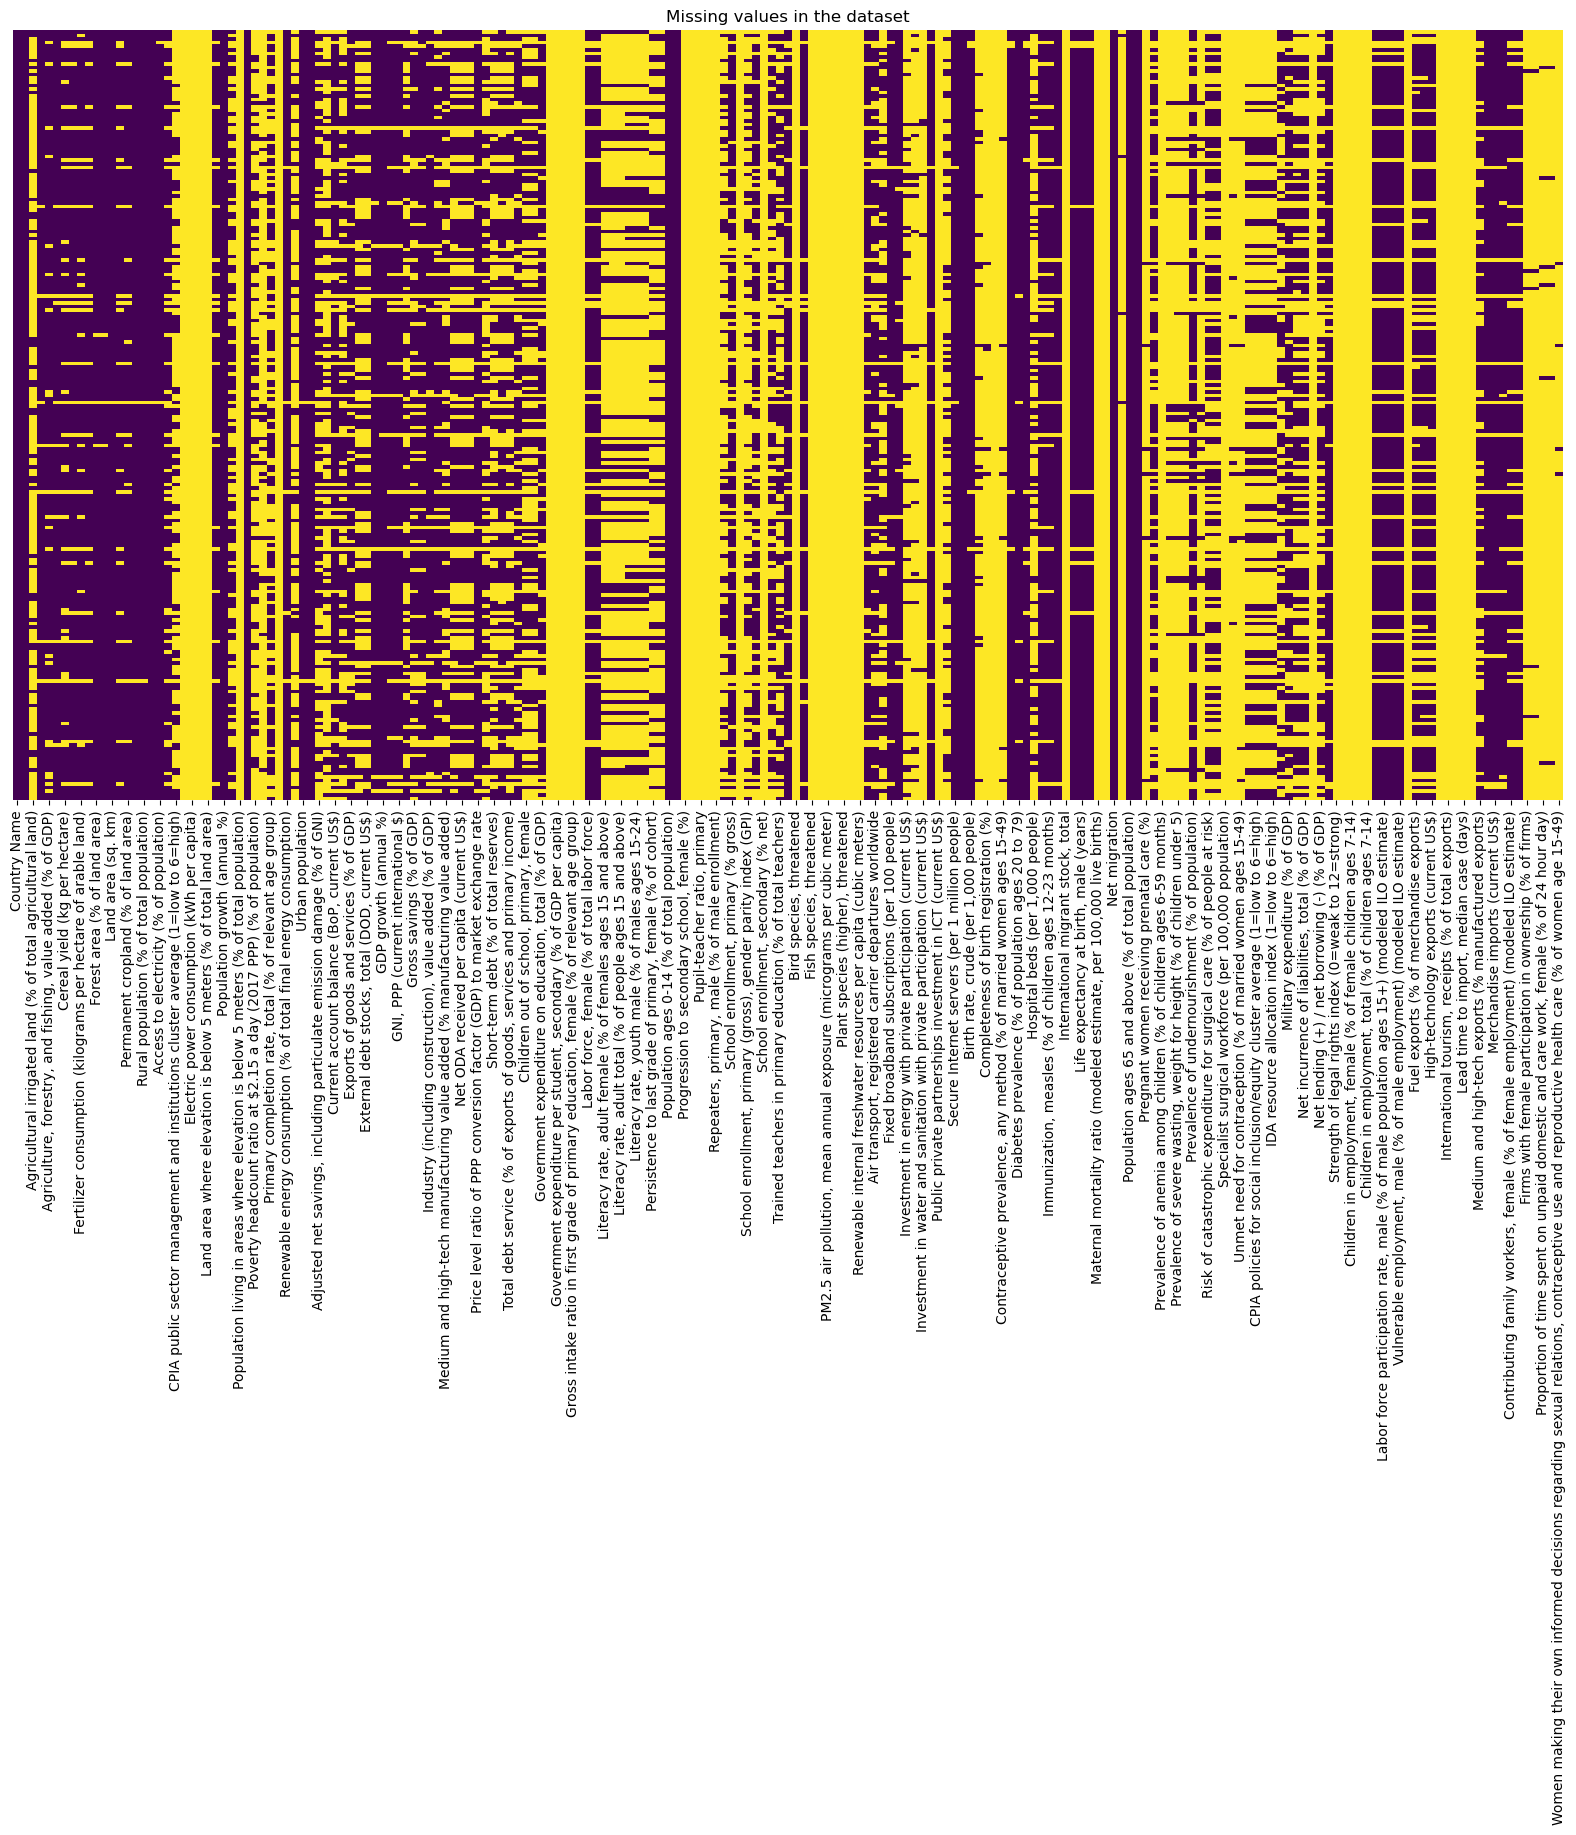

In [13]:
missing_values_plot(df)

### Remove columns with more than 50% missing values

In [14]:
# remove columns with more than 50% missing values
df_without_missing = df.dropna(thresh=df.shape[0]*0.5, axis=1)
df_without_missing

Country Name  Year  Agricultural land (% of land area)  \
0              Afghanistan  2021                               58.74   
1                  Albania  2021                               41.47   
2                  Algeria  2021                               17.35   
3           American Samoa  2021                               14.50   
4                  Andorra  2021                               39.91   
..                     ...   ...                                 ...   
211  Virgin Islands (U.S.)  2021                                9.43   
212     West Bank and Gaza  2021                               64.93   
213            Yemen, Rep.  2021                               44.42   
214                 Zambia  2021                               32.07   
215               Zimbabwe  2021                               41.88   

     Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                                33.60            
1                                                18.36            
2                                                11.23            
3                                                  NaN            
4                                                 0.53            
..                                                 ...            
211                                                NaN            
212                                               6.32            
213                                                NaN            
214                                               3.00            
215                                               8.85            

     Arable land (% of land area)  Cereal yield (kg per hectare)  \
0                           12.00                         2099.0   
1                           21.89                         5144.7   
2                            3.16                         1433.7   
3                            4.85                            NaN   
4                            1.59                            NaN   
..                            ...                            ...   
211                          2.57                            NaN   
212                          6.95                         2251.9   
213                          2.19                         1524.8   
214                          5.11                         2525.0   
215                         10.34                         1545.3   

     Crop production index (2014-2016 = 100)  \
0                                     125.67   
1                                     114.68   
2                                     108.76   
3                                        NaN   
4                                        NaN   
..                                       ...   
211                                      NaN   
212                                   117.31   
213                                   124.71   
214                                   136.31   
215                                   129.97   

     Fertilizer consumption (kilograms per hectare of arable land)  \
0                                                 5.20               
1                                                  NaN               
2                                                20.68               
3                                                  NaN               
4                                                  NaN               
..                                                 ...               
211                                                NaN               
212                                             371.97               
213                                              10.63               
214                                              63.90               
215                                              25.98               

     Food production index (2014-2016 = 100)  Forest area (% of land area)  \
0                              

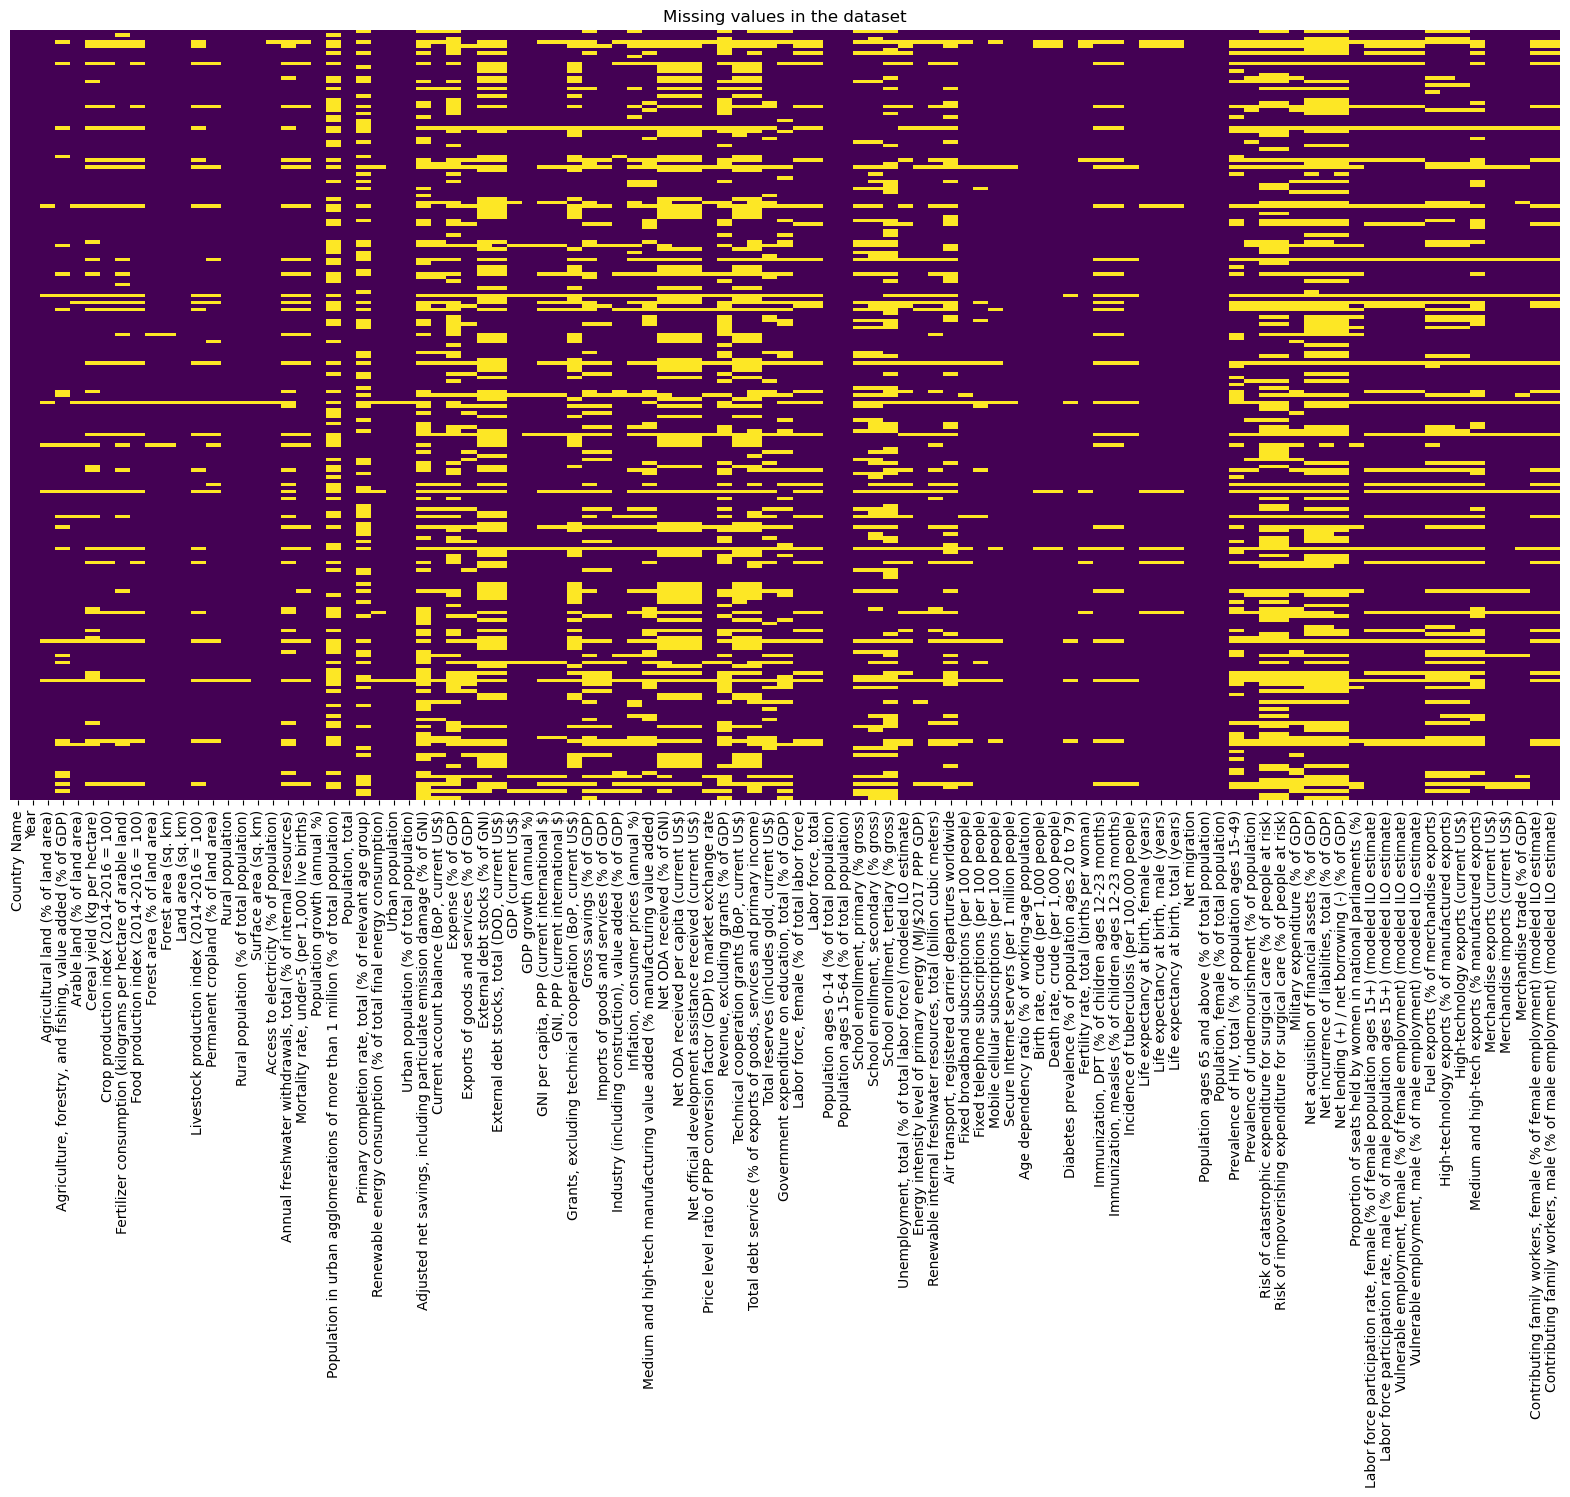

In [15]:
missing_values_plot(df_without_missing)

In [16]:
# show persentage of missing values for each column
missing_percentage = list(df_without_missing.isnull().mean() * 100)

print("The total columns remain:", len(missing_percentage))
print("Missing values percentage for each column:")
for i in range(len(missing_percentage)):
    print(df_without_missing.columns[i], "=>", missing_percentage[i])

The total columns remain: 103
Missing values percentage for each column:
Country Name => 0.0
Year => 0.0
Agricultural land (% of land area) => 3.2407407407407405
Agriculture, forestry, and fishing, value added (% of GDP) => 11.574074074074074
Arable land (% of land area) => 4.62962962962963
Cereal yield (kg per hectare) => 17.59259259259259
Crop production index (2014-2016 = 100) => 10.185185185185185
Fertilizer consumption (kilograms per hectare of arable land) => 13.425925925925927
Food production index (2014-2016 = 100) => 10.185185185185185
Forest area (% of land area) => 1.3888888888888888
Forest area (sq. km) => 1.3888888888888888
Land area (sq. km) => 0.4629629629629629
Livestock production index (2014-2016 = 100) => 10.648148148148149
Permanent cropland (% of land area) => 7.87037037037037
Rural population => 0.9259259259259258
Rural population (% of total population) => 0.9259259259259258
Surface area (sq. km) => 0.4629629629629629
Access to electricity (% of population) => 0.

In [17]:
# seperate type of columns 0%, 0-5%, 5-15%, 15-30%, 30-50% missing values
zero_missing = []
zero_to_five_missing = []
five_to_fifteen_missing = []
fifteen_to_thirty_missing = []
thirty_to_fifty_missing = []

for i in range(len(missing_percentage)):
    if missing_percentage[i] == 0:
        zero_missing.append(df_without_missing.columns[i])
    elif missing_percentage[i] > 0 and missing_percentage[i] <= 5:
        zero_to_five_missing.append(df_without_missing.columns[i])
    elif missing_percentage[i] > 5 and missing_percentage[i] <= 15:
        five_to_fifteen_missing.append(df_without_missing.columns[i])
    elif missing_percentage[i] > 15 and missing_percentage[i] <= 30:
        fifteen_to_thirty_missing.append(df_without_missing.columns[i])
    elif missing_percentage[i] > 30 and missing_percentage[i] <= 50:
        thirty_to_fifty_missing.append(df_without_missing.columns[i])

### Zero missing value

In [18]:
# show columns with 0% missing values
print("The total columns with 0% missing values:", len(zero_missing))
print("Columns with 0% missing values:")
for column in zero_missing:
    print(column)

The total columns with 0% missing values: 10
Columns with 0% missing values:
Country Name
Year
Population growth (annual %)
Population, total
Population ages 0-14 (% of total population)
Population ages 15-64 (% of total population)
Age dependency ratio (% of working-age population)
Net migration
Population ages 65 and above (% of total population)
Population, female (% of total population)


### Handle 0-5% missing values

In [19]:
# show columns with 0-5% missing values
print("The total columns with 0-5% missing values:", len(zero_to_five_missing))
print("Columns with 0-5% missing values:")
for column in zero_to_five_missing:
    print(column)
    

The total columns with 0-5% missing values: 24
Columns with 0-5% missing values:
Agricultural land (% of land area)
Arable land (% of land area)
Forest area (% of land area)
Forest area (sq. km)
Land area (sq. km)
Rural population
Rural population (% of total population)
Surface area (sq. km)
Access to electricity (% of population)
Renewable energy consumption (% of total final energy consumption)
Urban population
Urban population (% of total population)
GDP (current US$)
GDP growth (annual %)
Mobile cellular subscriptions (per 100 people)
Secure Internet servers (per 1 million people)
Birth rate, crude (per 1,000 people)
Death rate, crude (per 1,000 people)
Diabetes prevalence (% of population ages 20 to 79)
Fertility rate, total (births per woman)
Incidence of tuberculosis (per 100,000 people)
Life expectancy at birth, female (years)
Life expectancy at birth, male (years)
Life expectancy at birth, total (years)


In [20]:
# show 0-5% missing values mean and median
for column in zero_to_five_missing:
    print(column, "=>", df_without_missing[column].mean(), df_without_missing[column].median())

Agricultural land (% of land area) => 37.367655502392346 38.53
Arable land (% of land area) => 14.024320388349516 10.295
Forest area (% of land area) => 31.711126760563378 30.27
Forest area (sq. km) => 188857.9564319249 20515.57
Land area (sq. km) => 600554.8560465116 91605.6
Rural population => 16003023.182242991 1735323.5
Rural population (% of total population) => 38.186261682242986 36.905
Surface area (sq. km) => 650362.7762790696 100430.0
Access to electricity (% of population) => 87.51121495327104 100.0
Renewable energy consumption (% of total final energy consumption) => 28.787203791469196 20.2
Urban population => 20717543.042056076 4022829.0
Urban population (% of total population) => 61.815093457943924 63.095
GDP (current US$) => 464871789833.48505 28144331507.0
GDP growth (annual %) => 6.204927536231884 5.15
Mobile cellular subscriptions (per 100 people) => 109.67106280193238 111.96
Secure Internet servers (per 1 million people) => 25989.72457943925 597.575
Birth rate, crude 

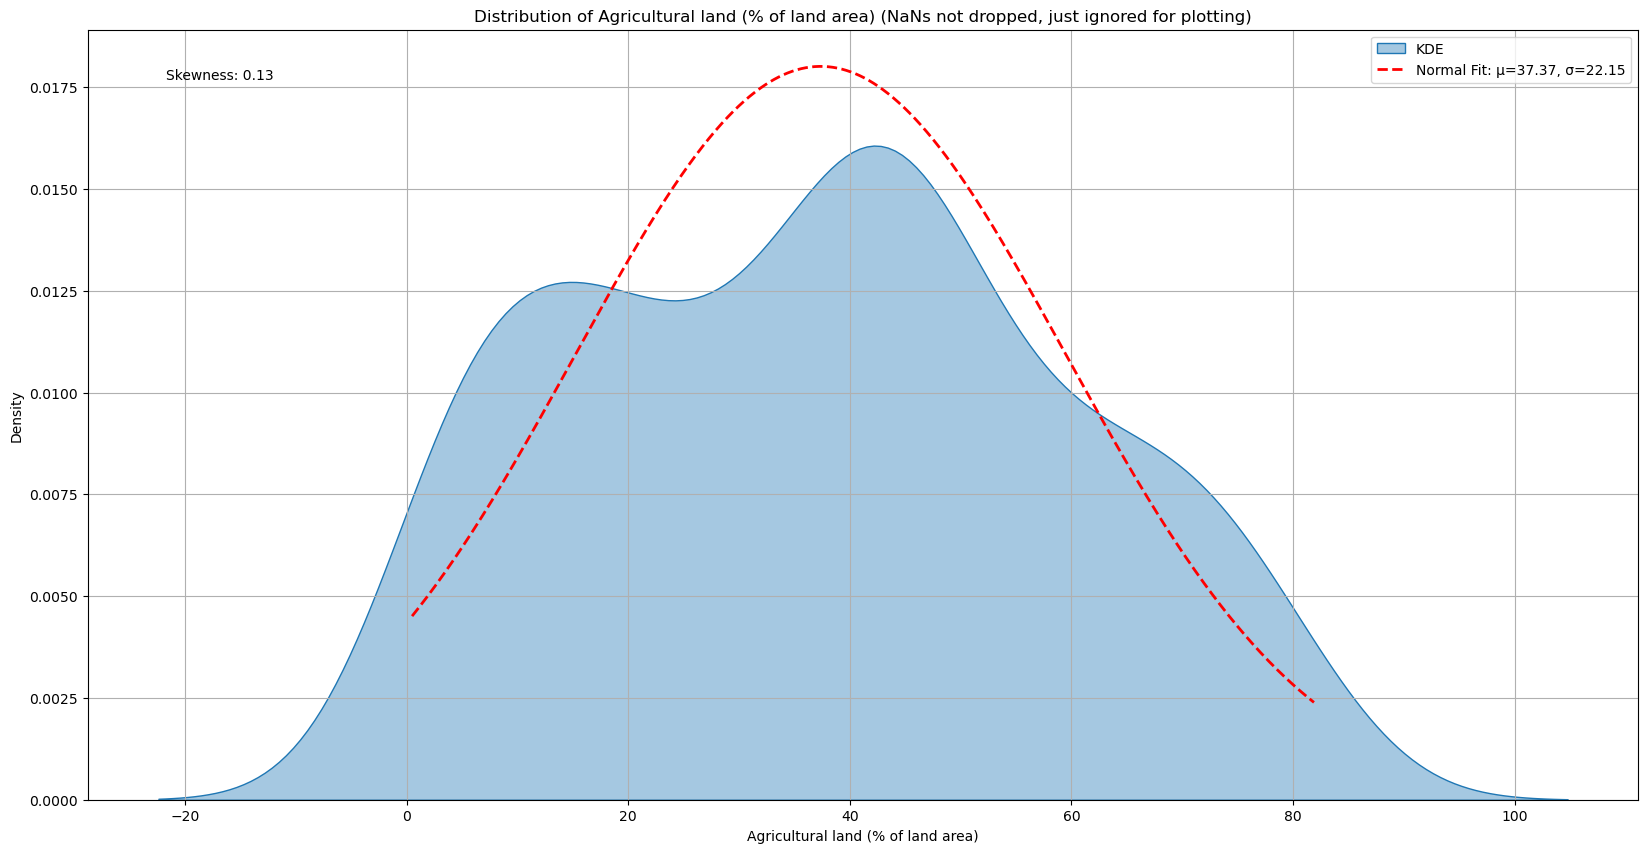

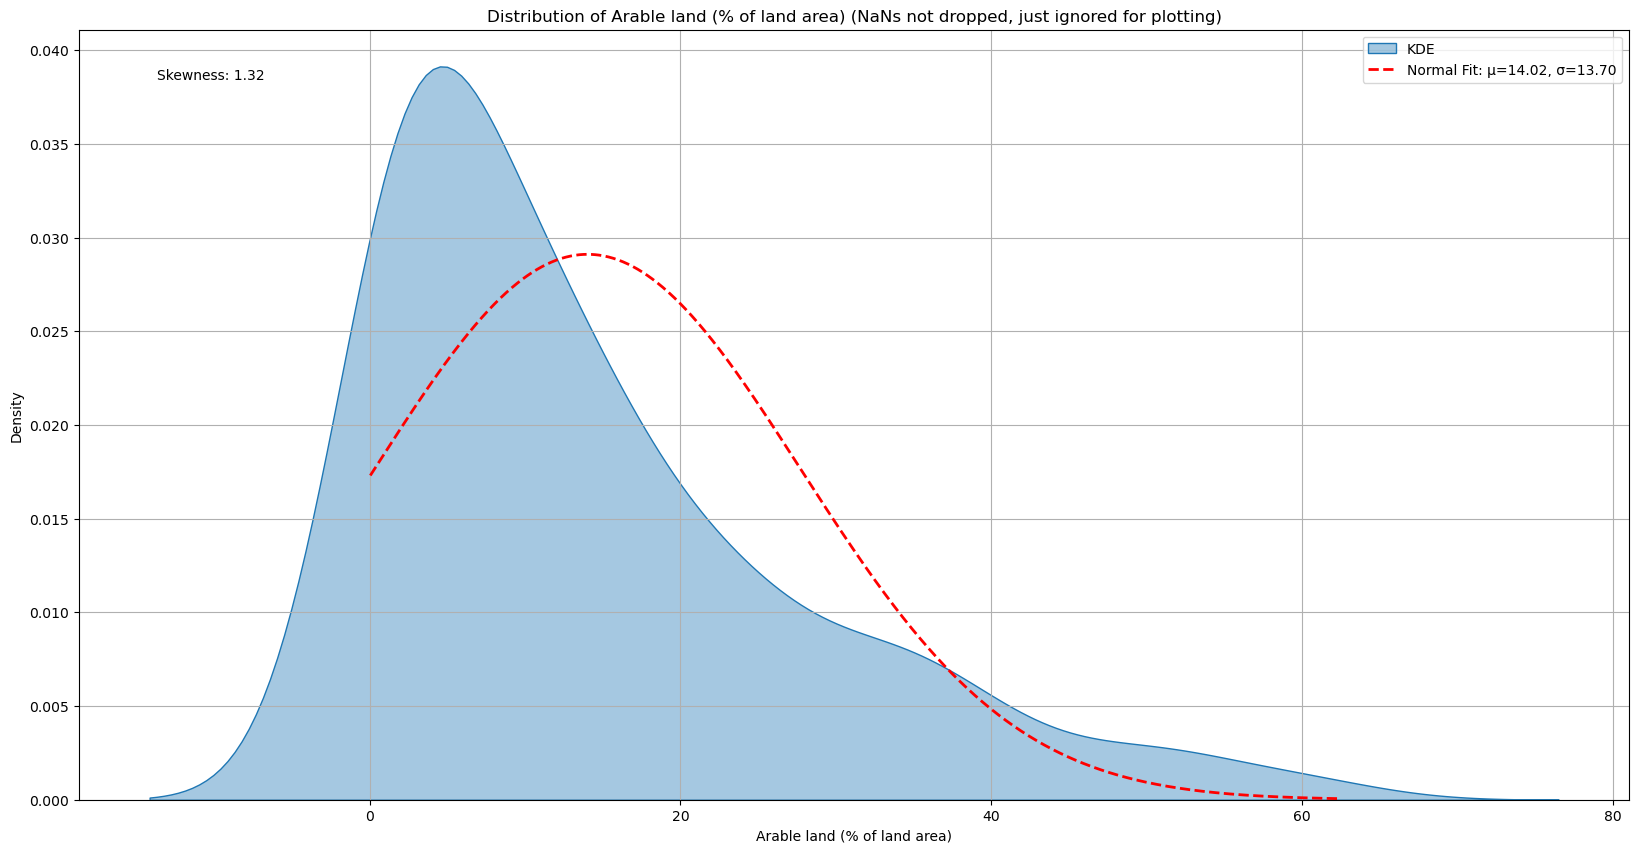

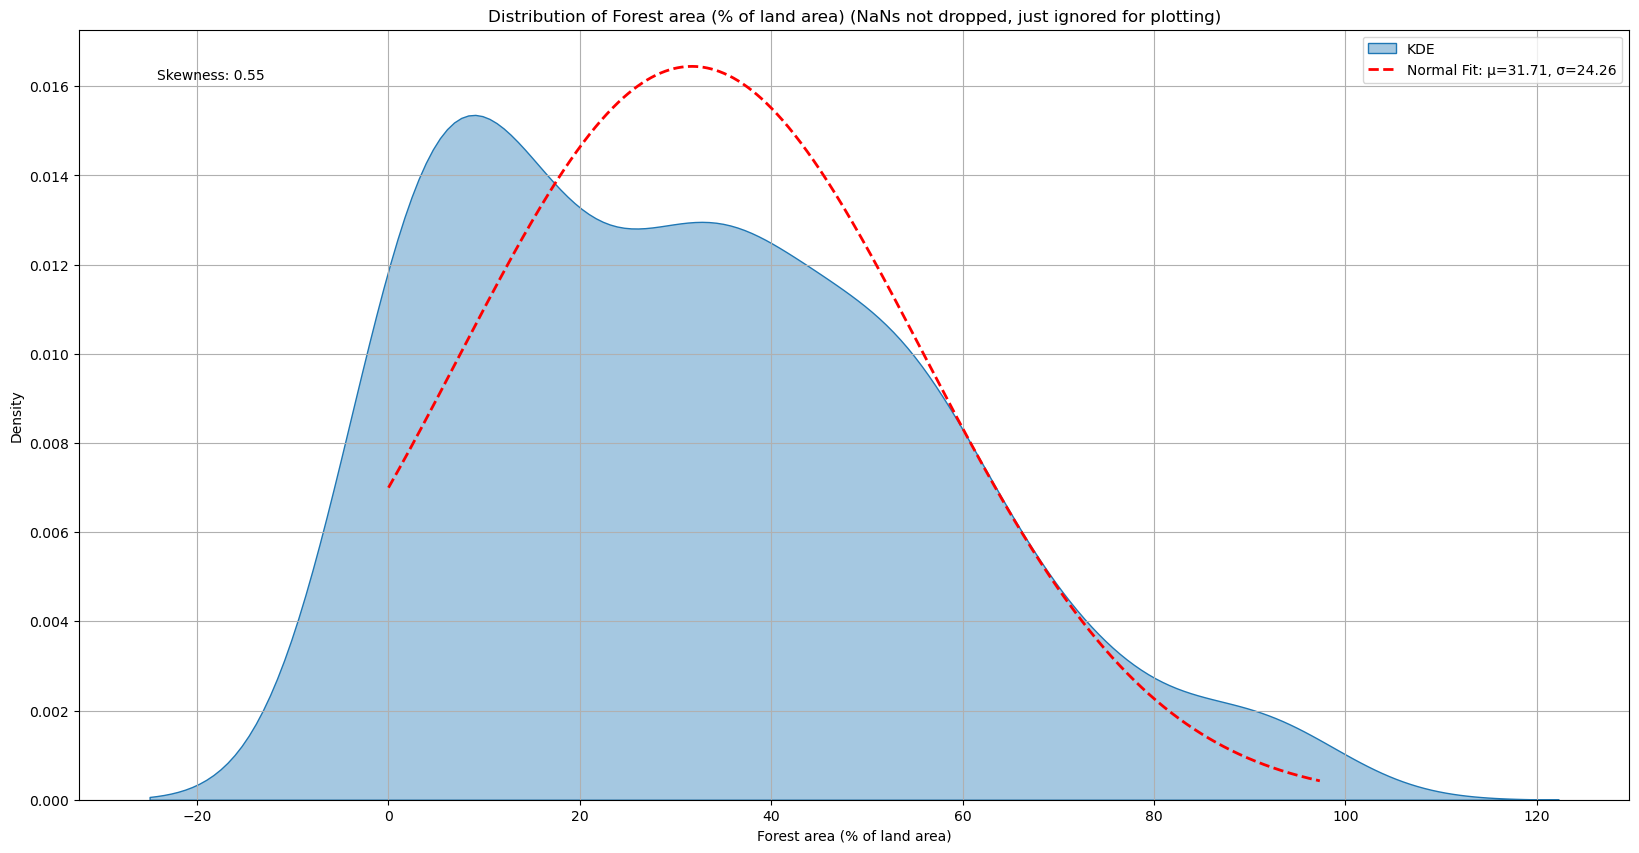

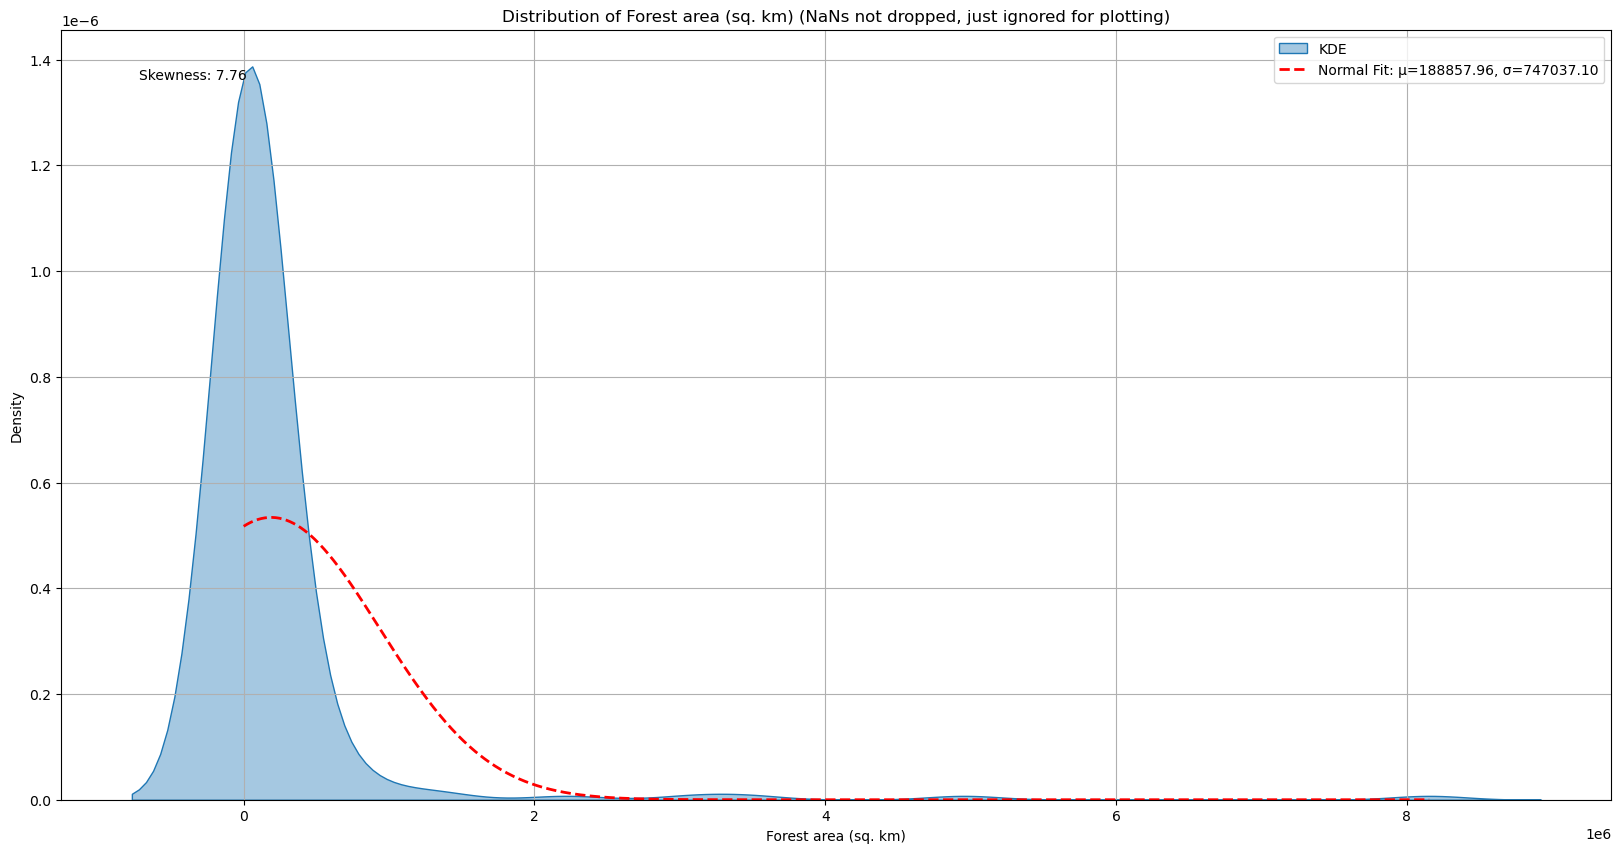

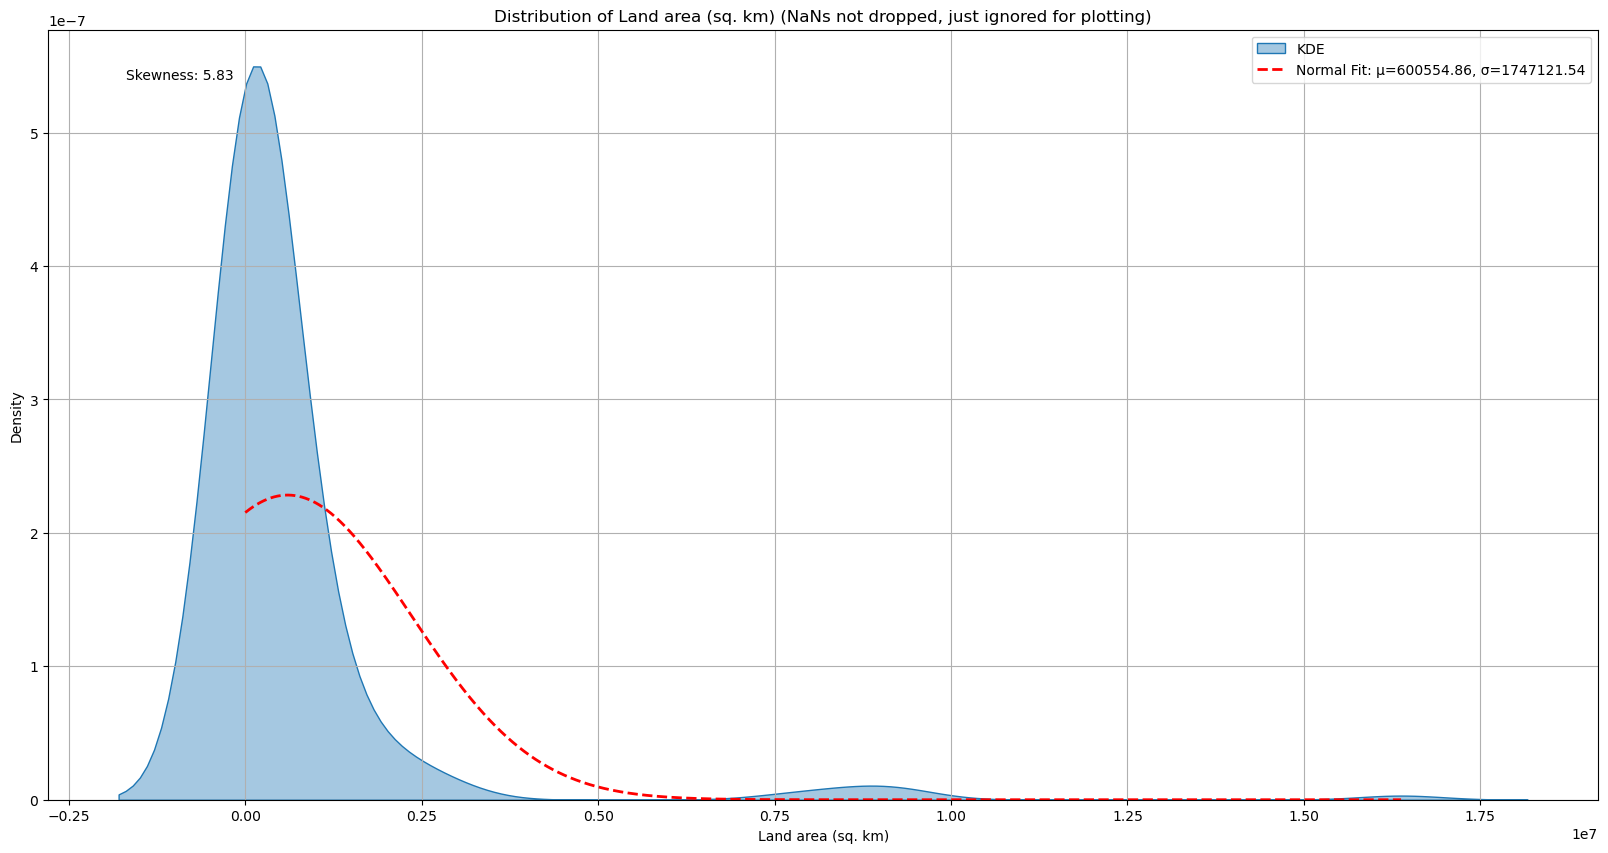

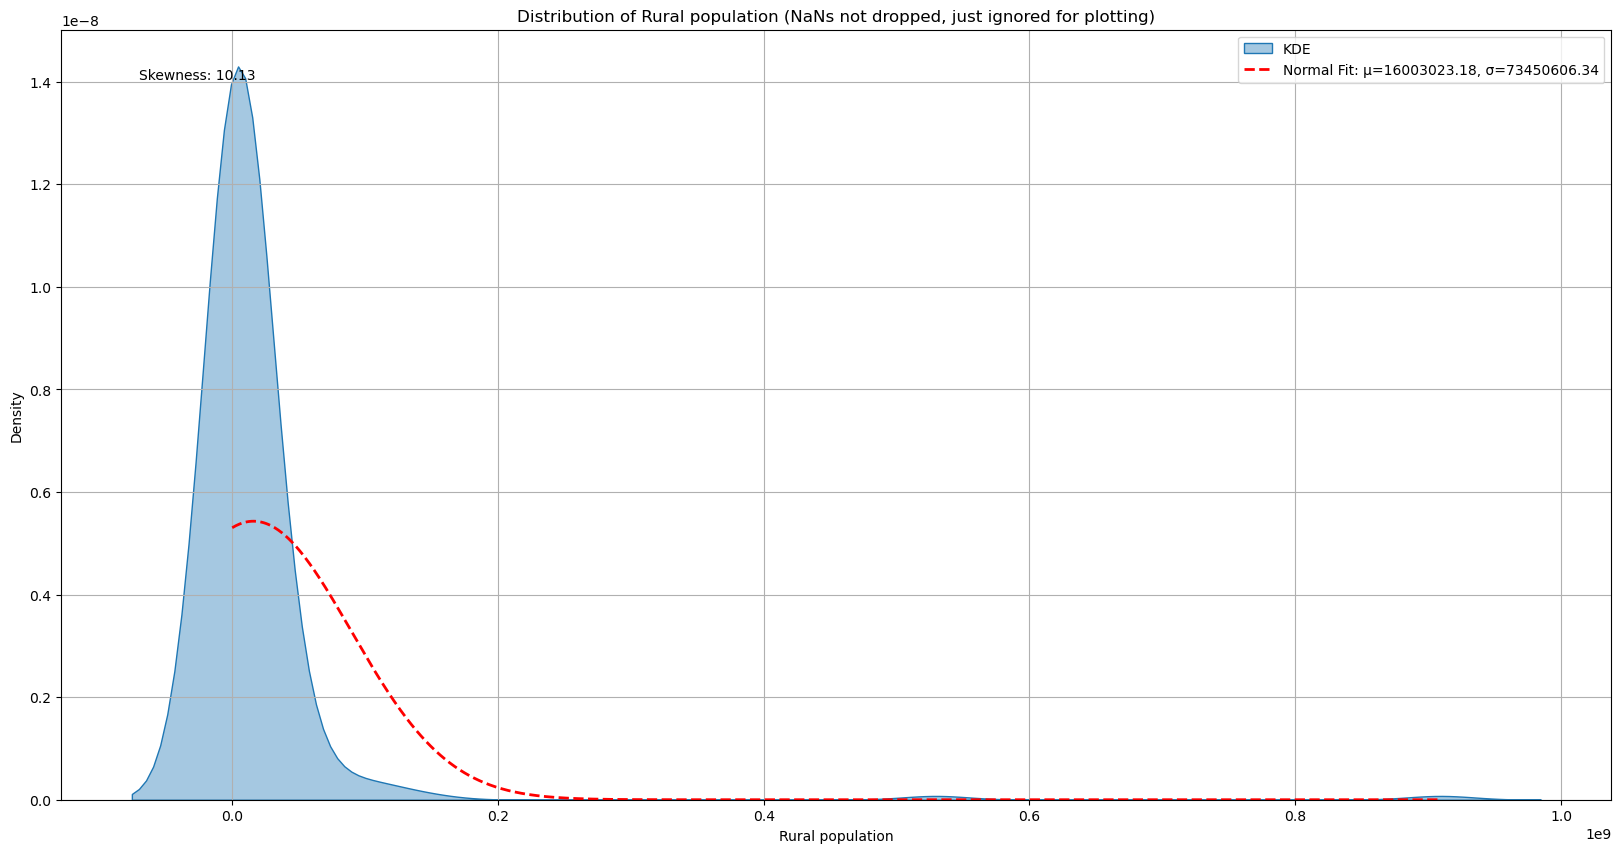

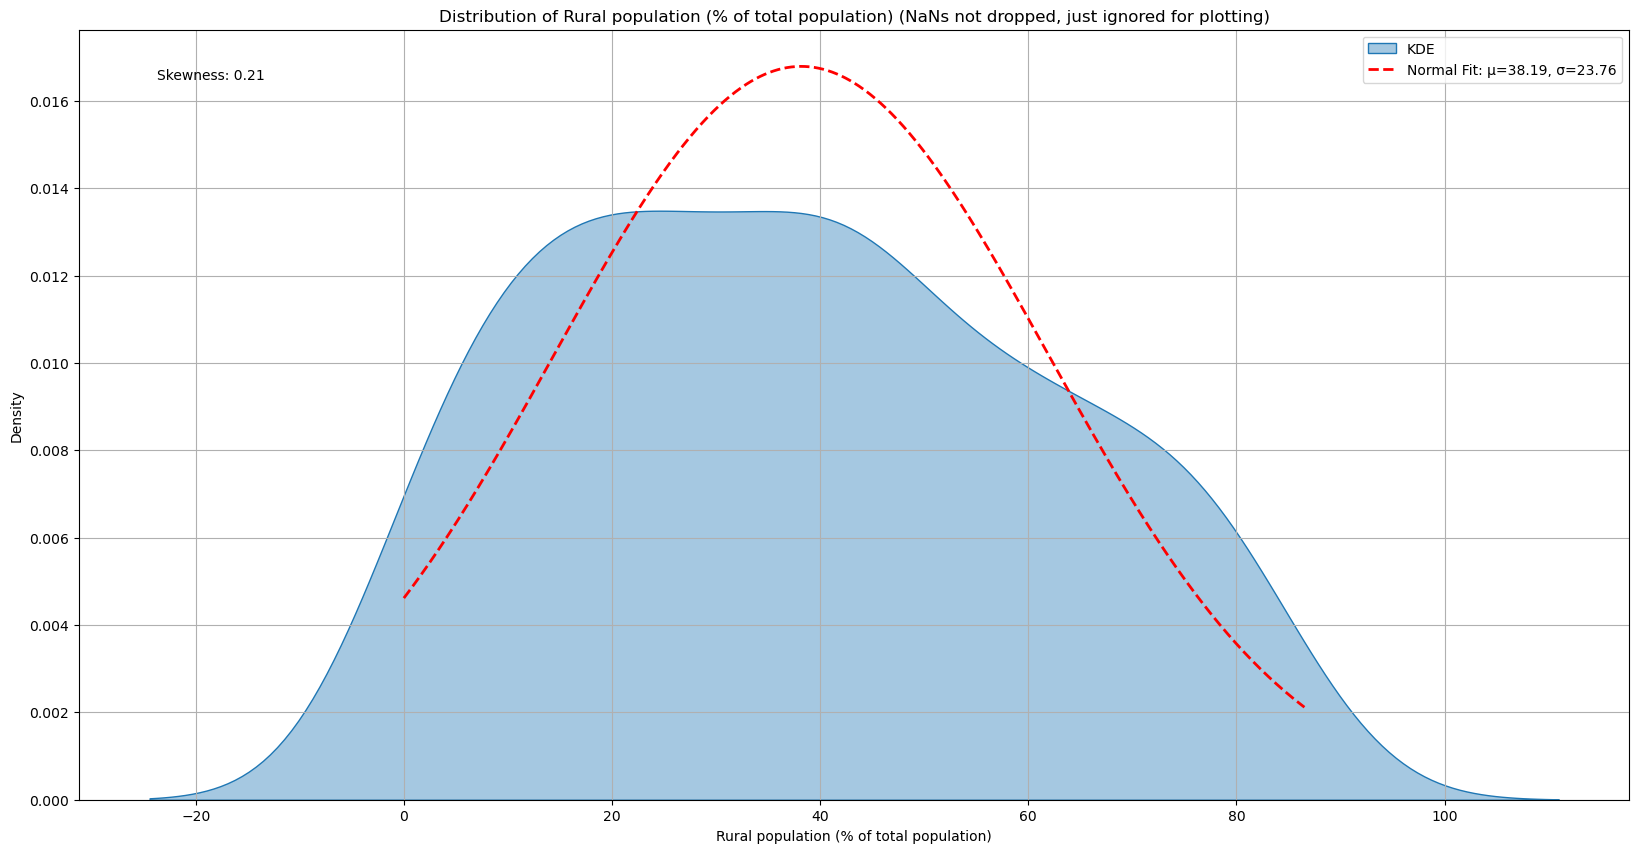

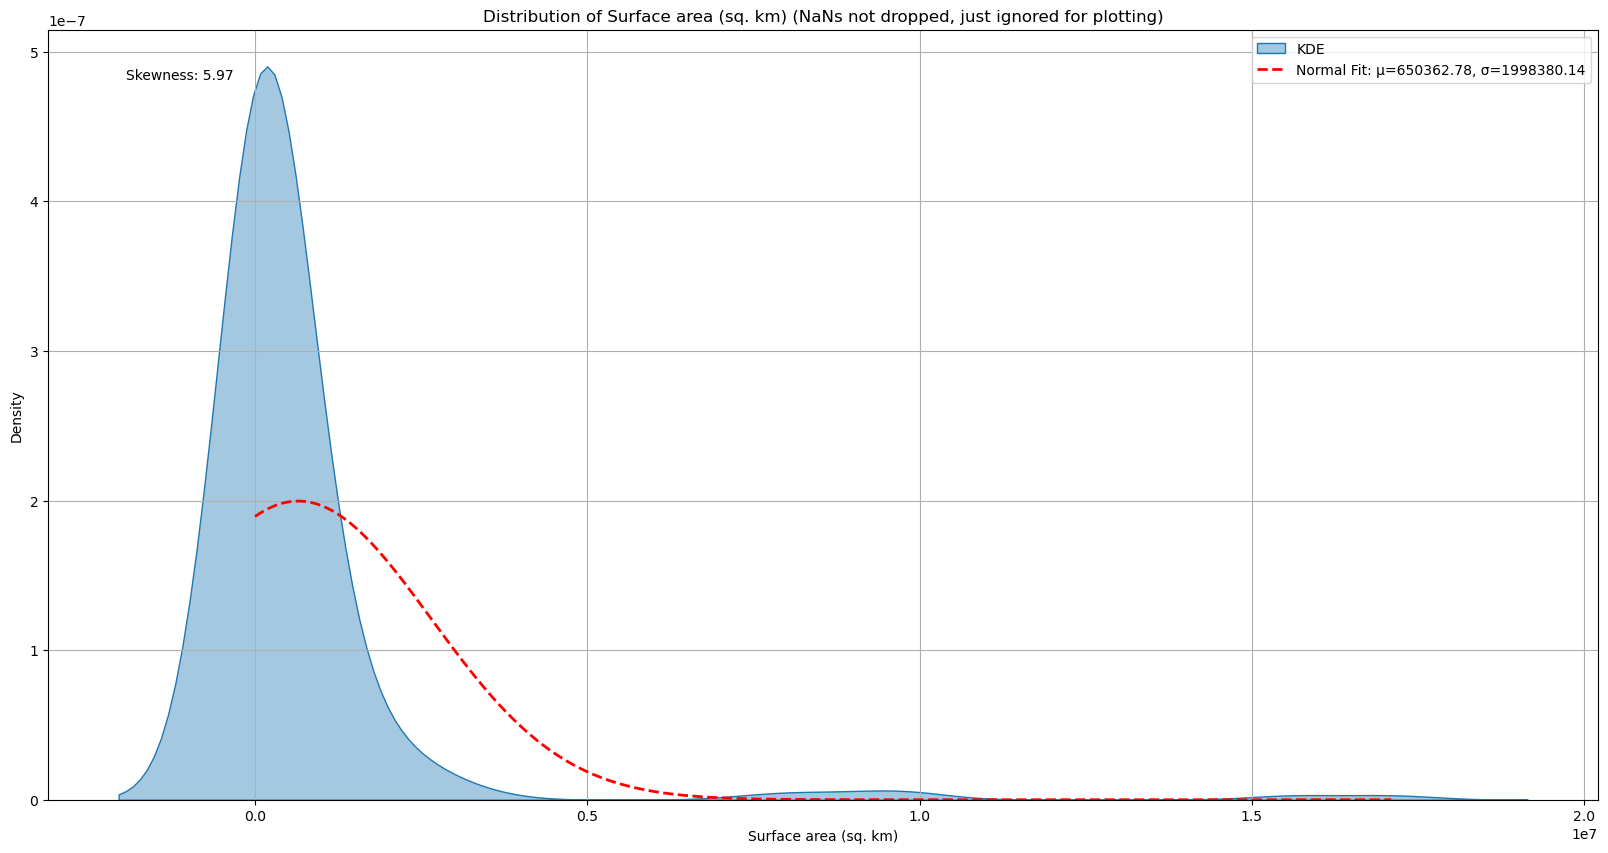

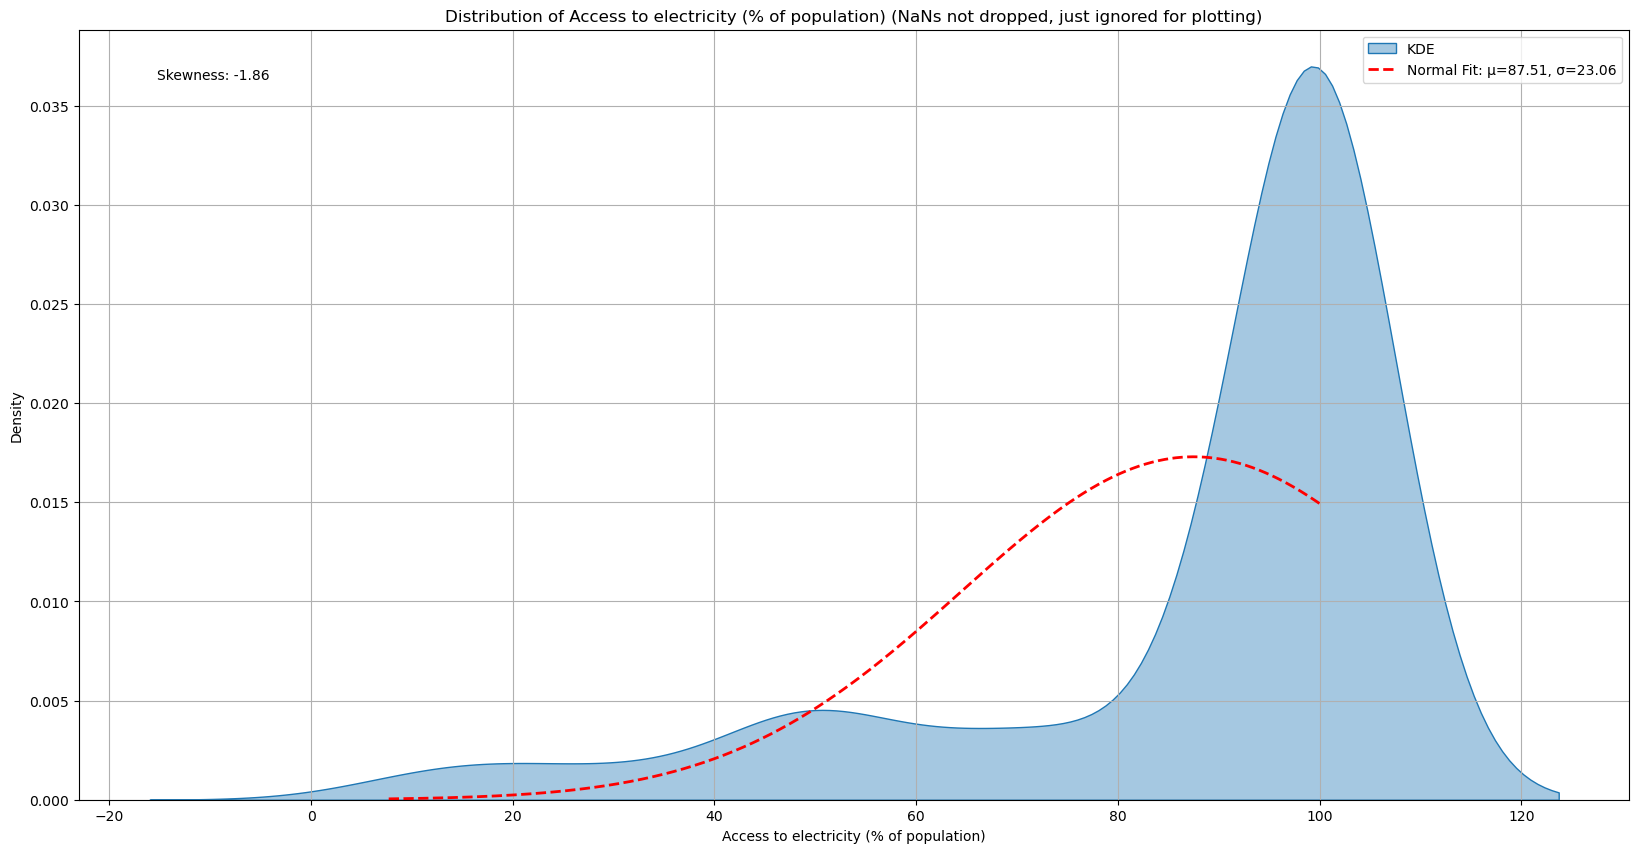

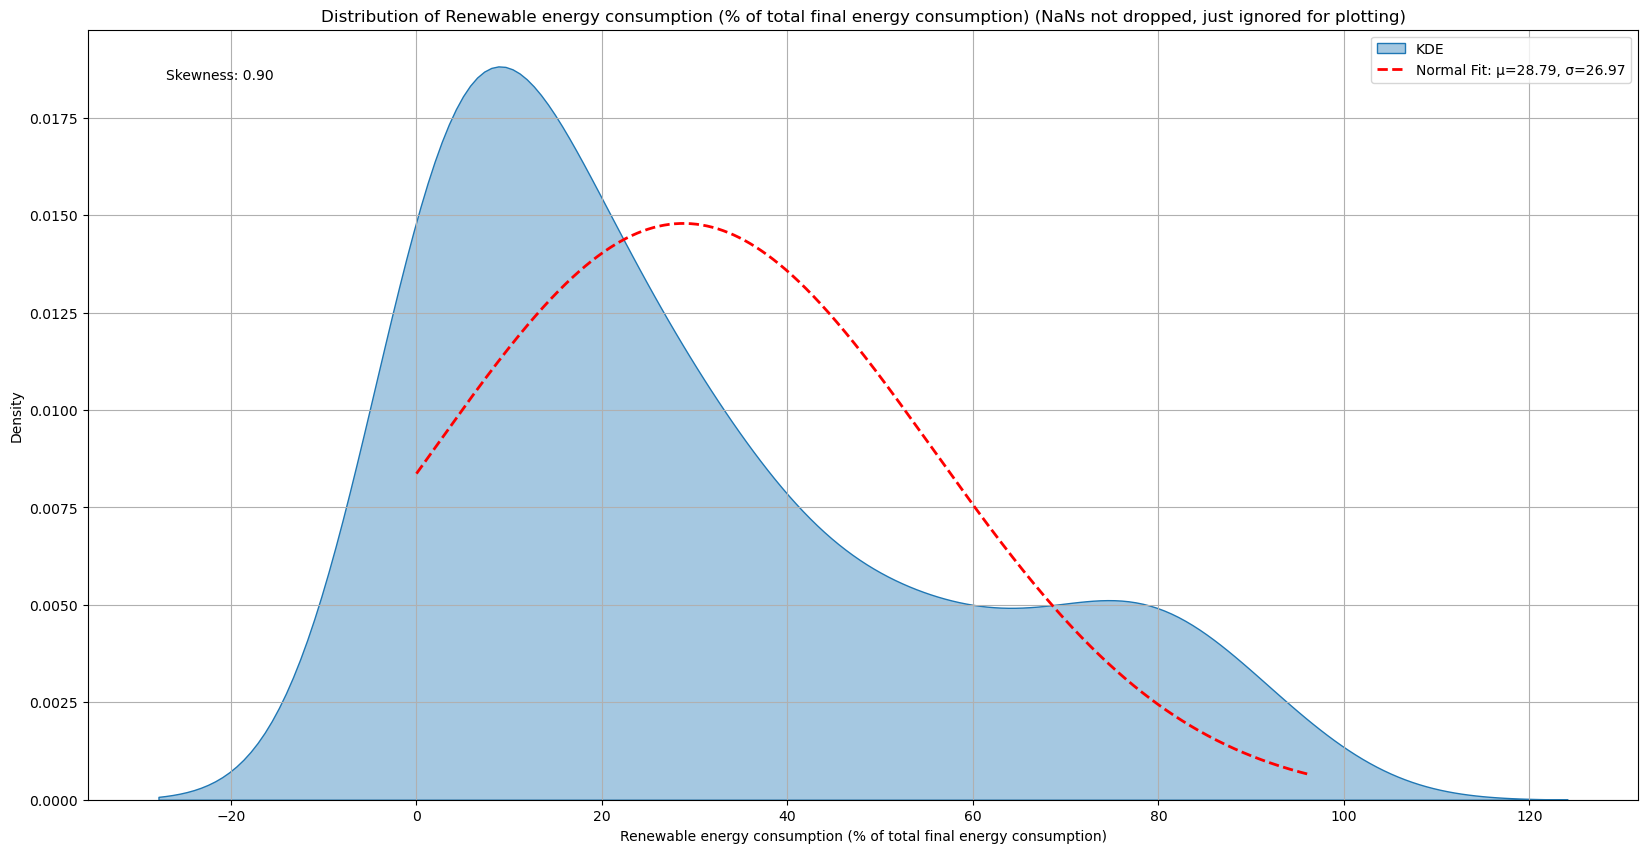

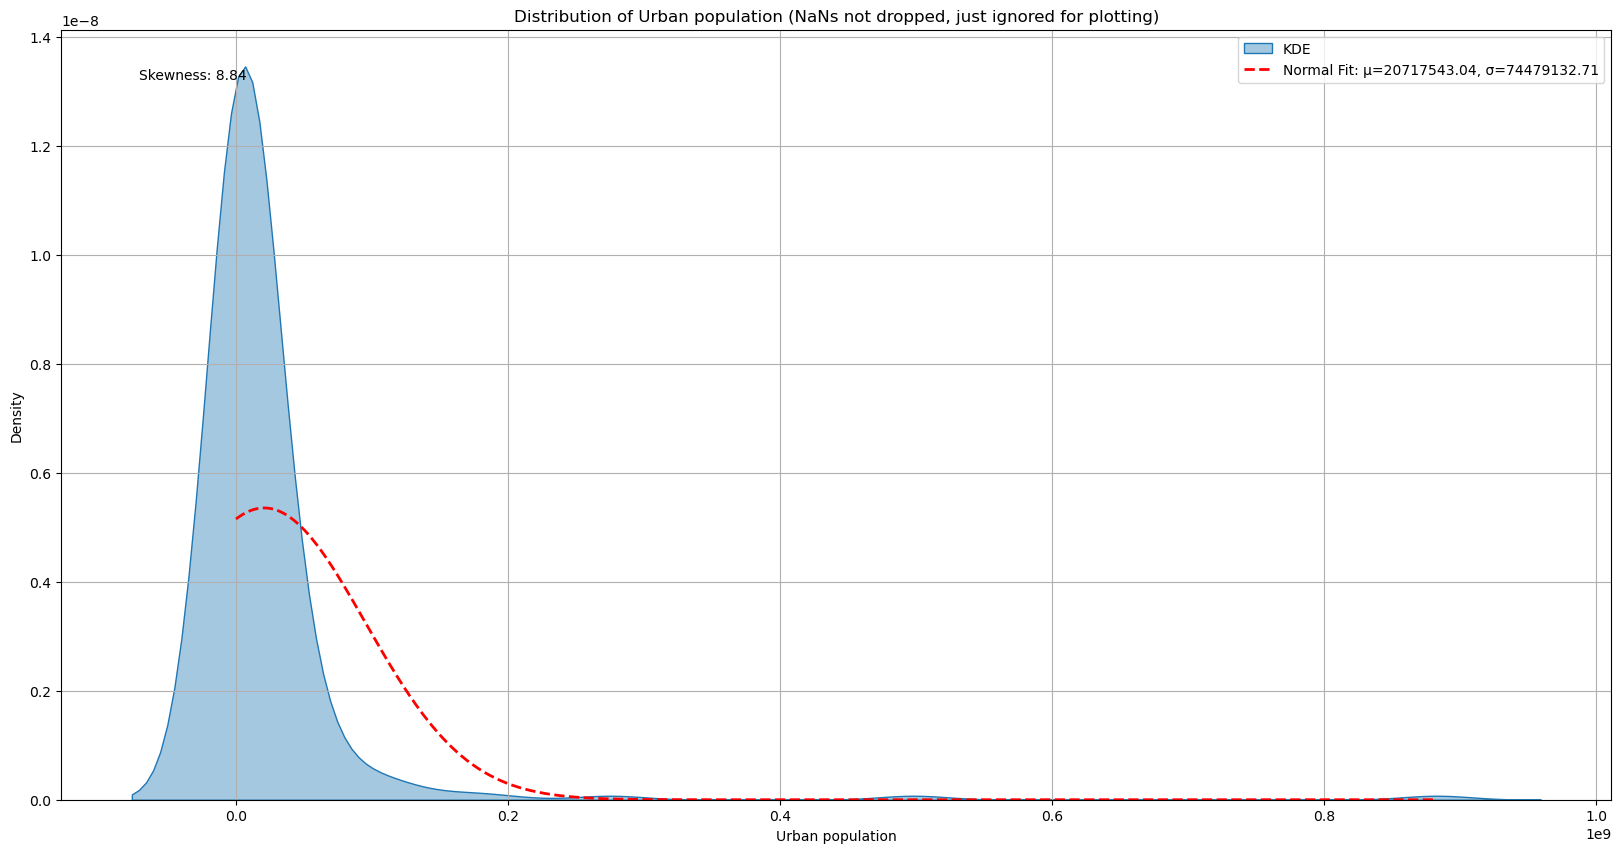

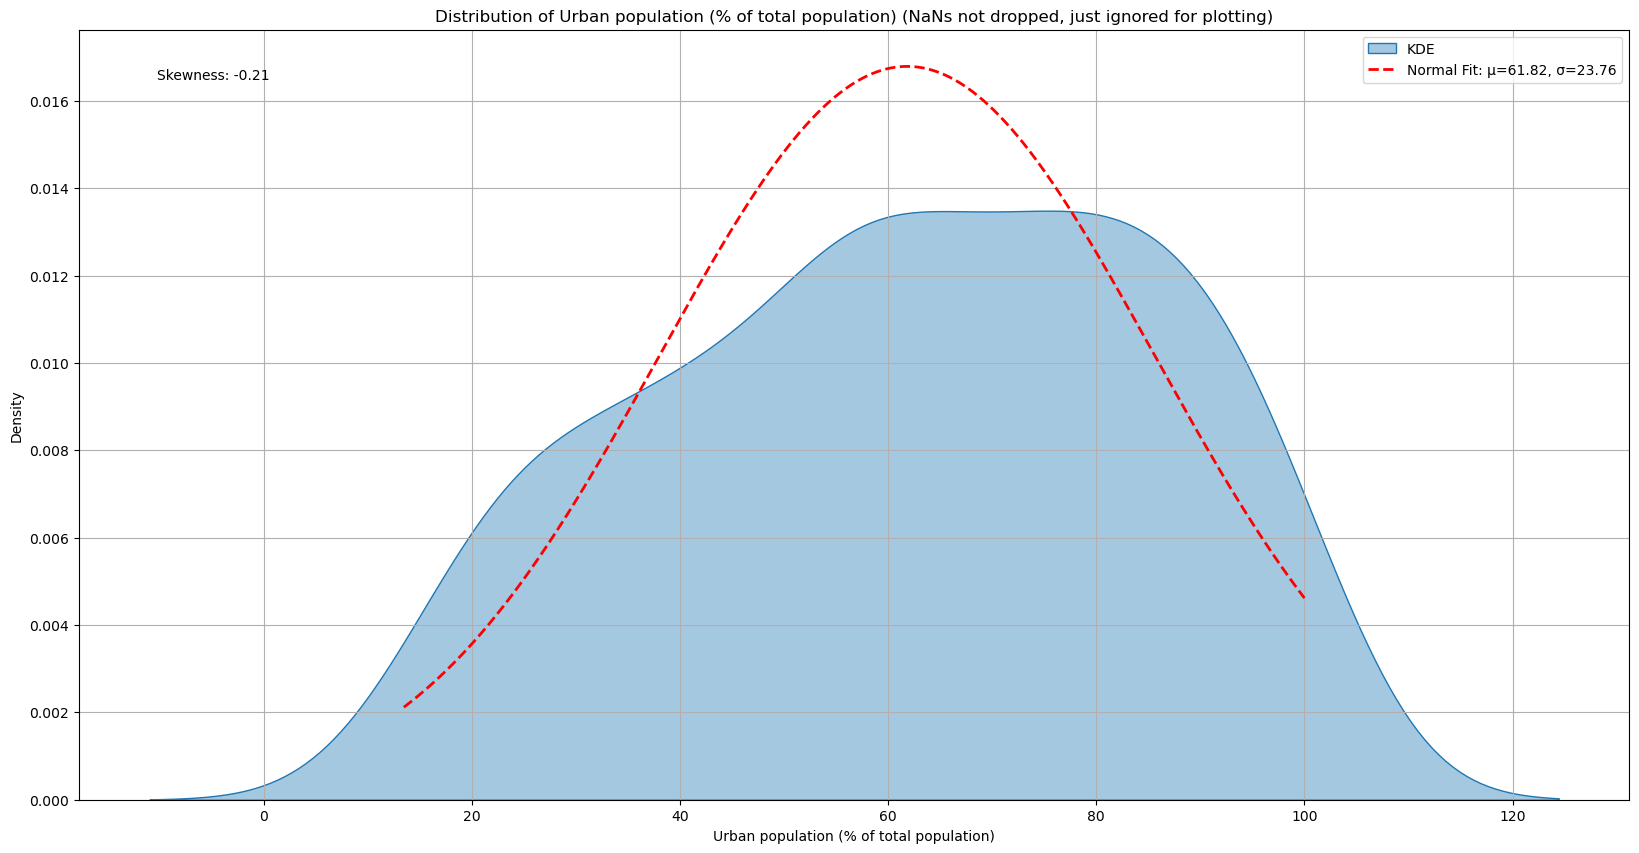

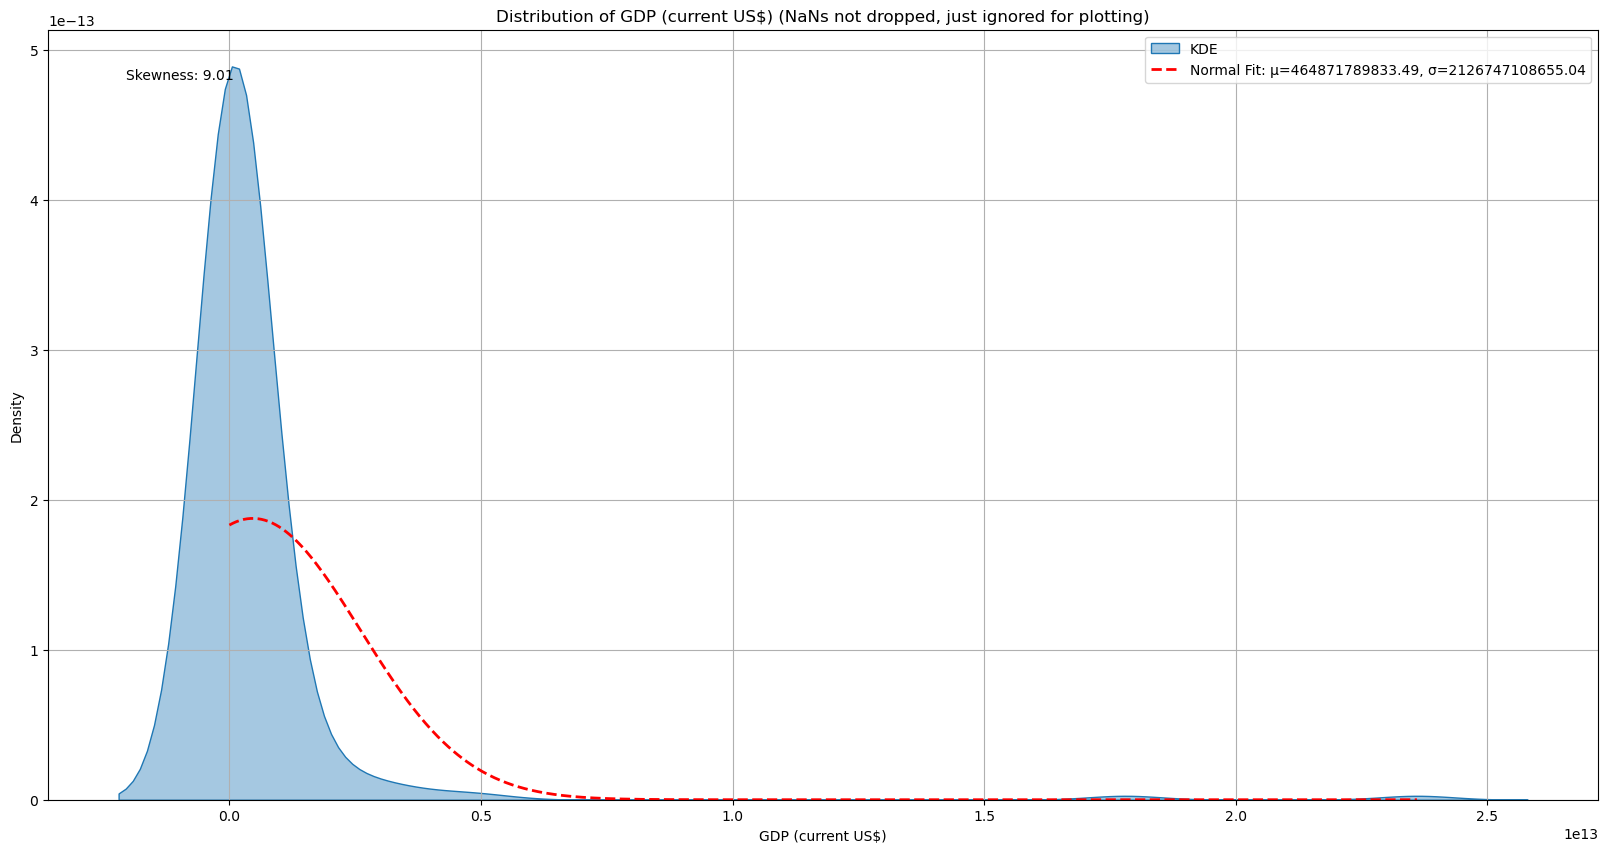

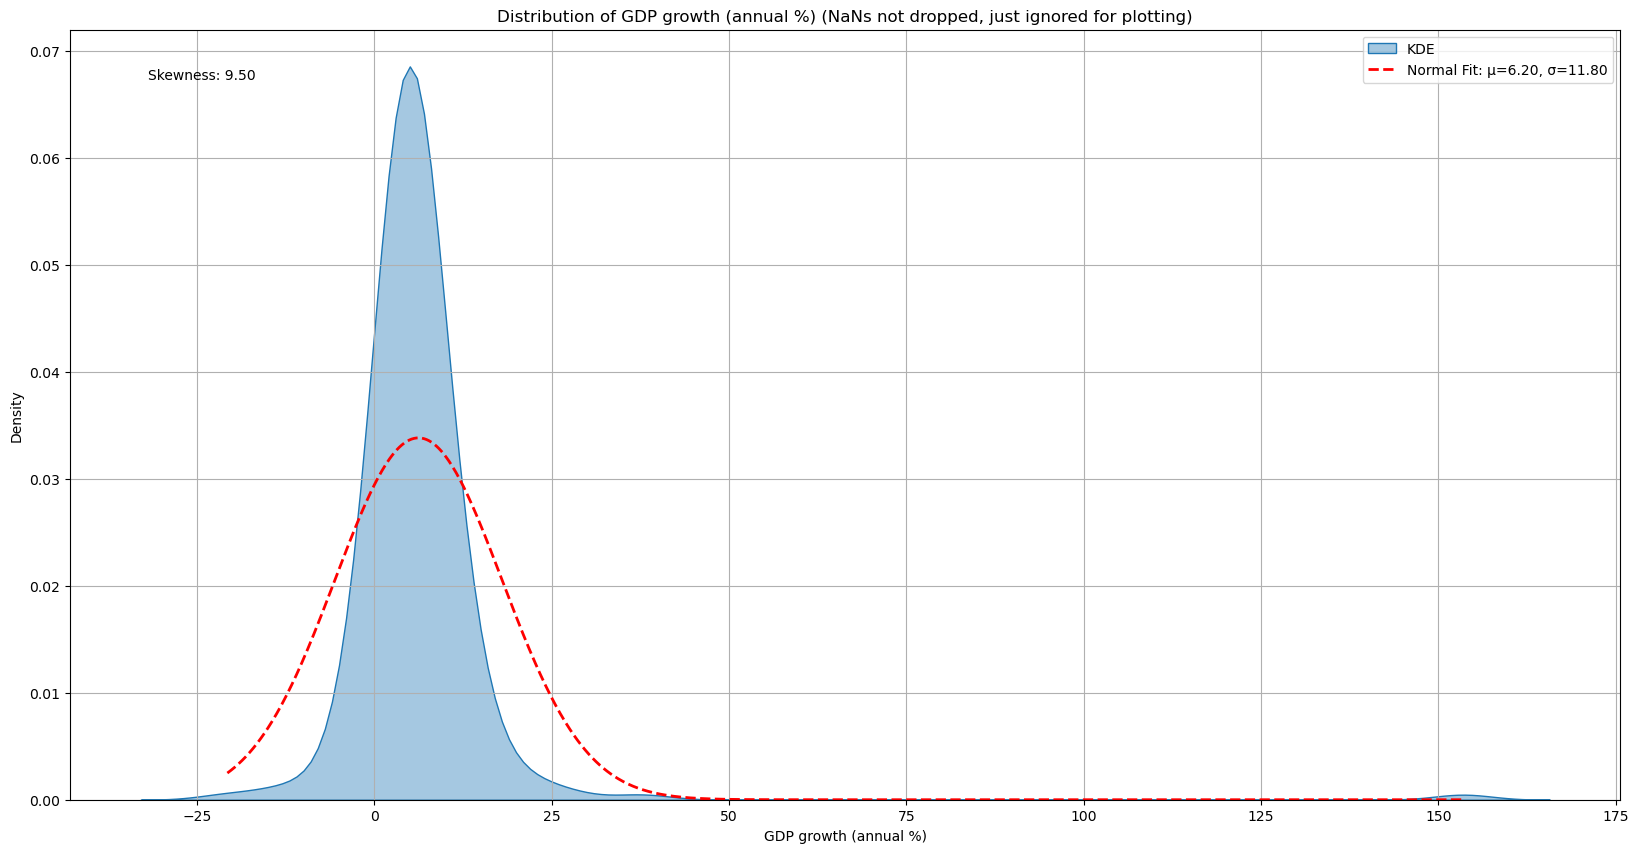

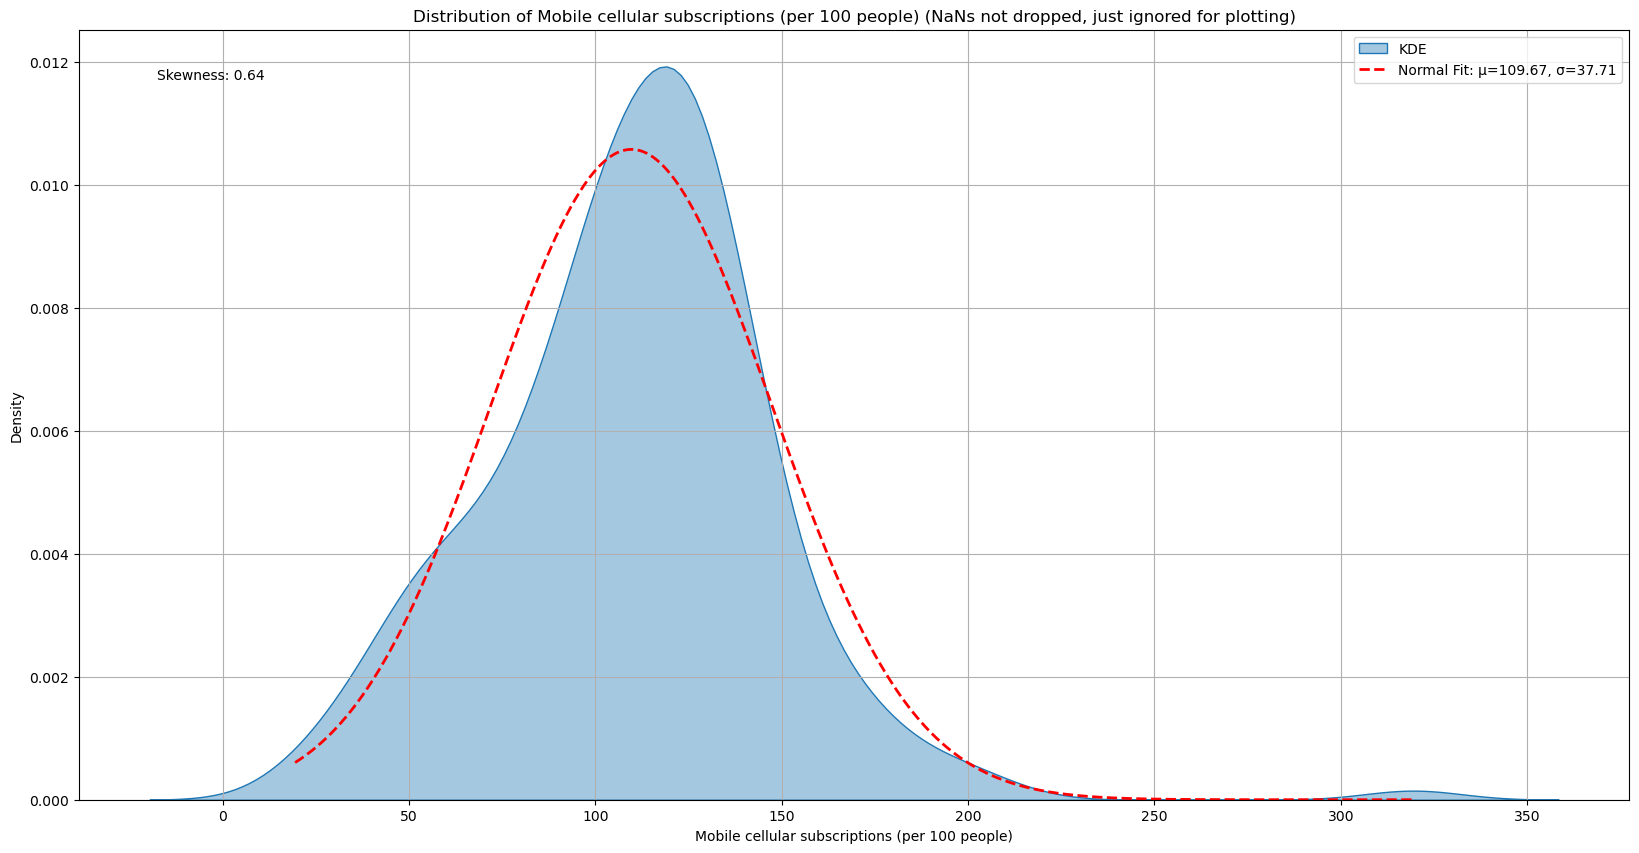

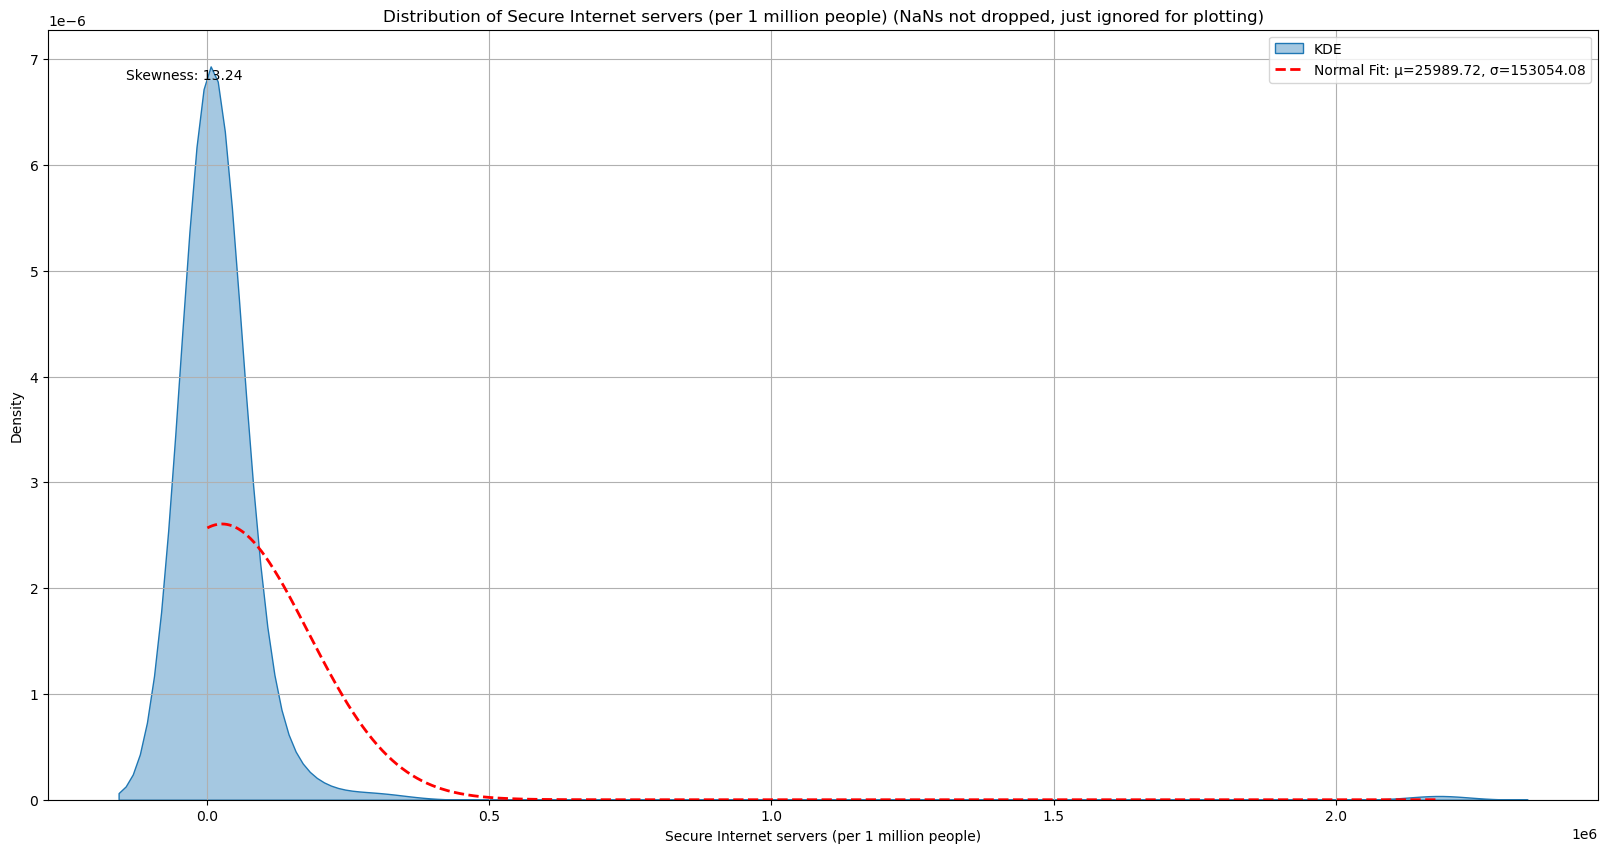

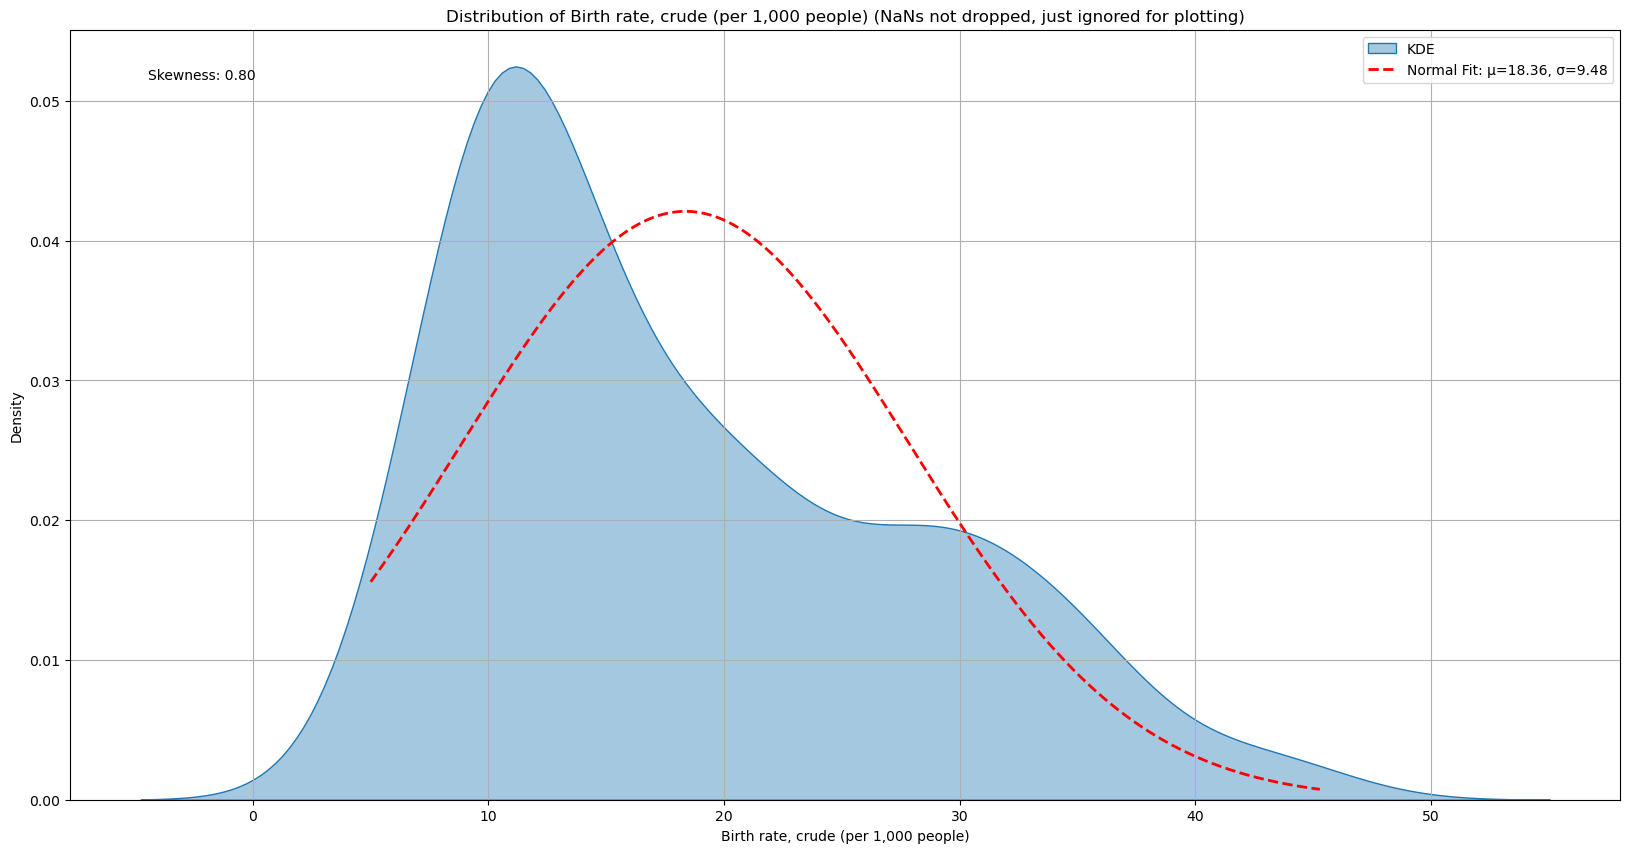

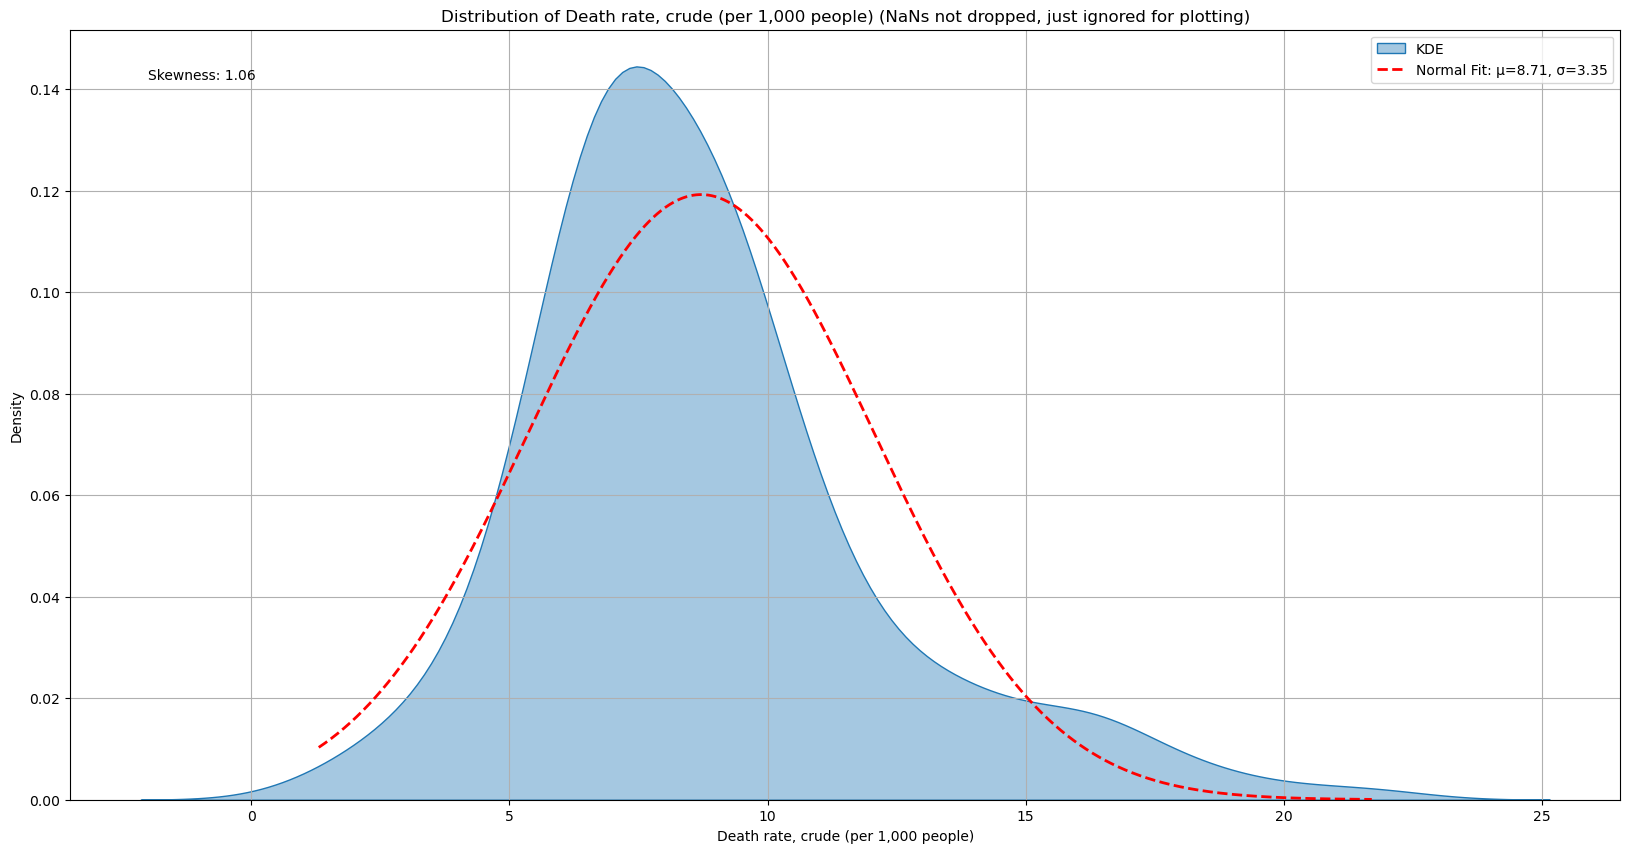

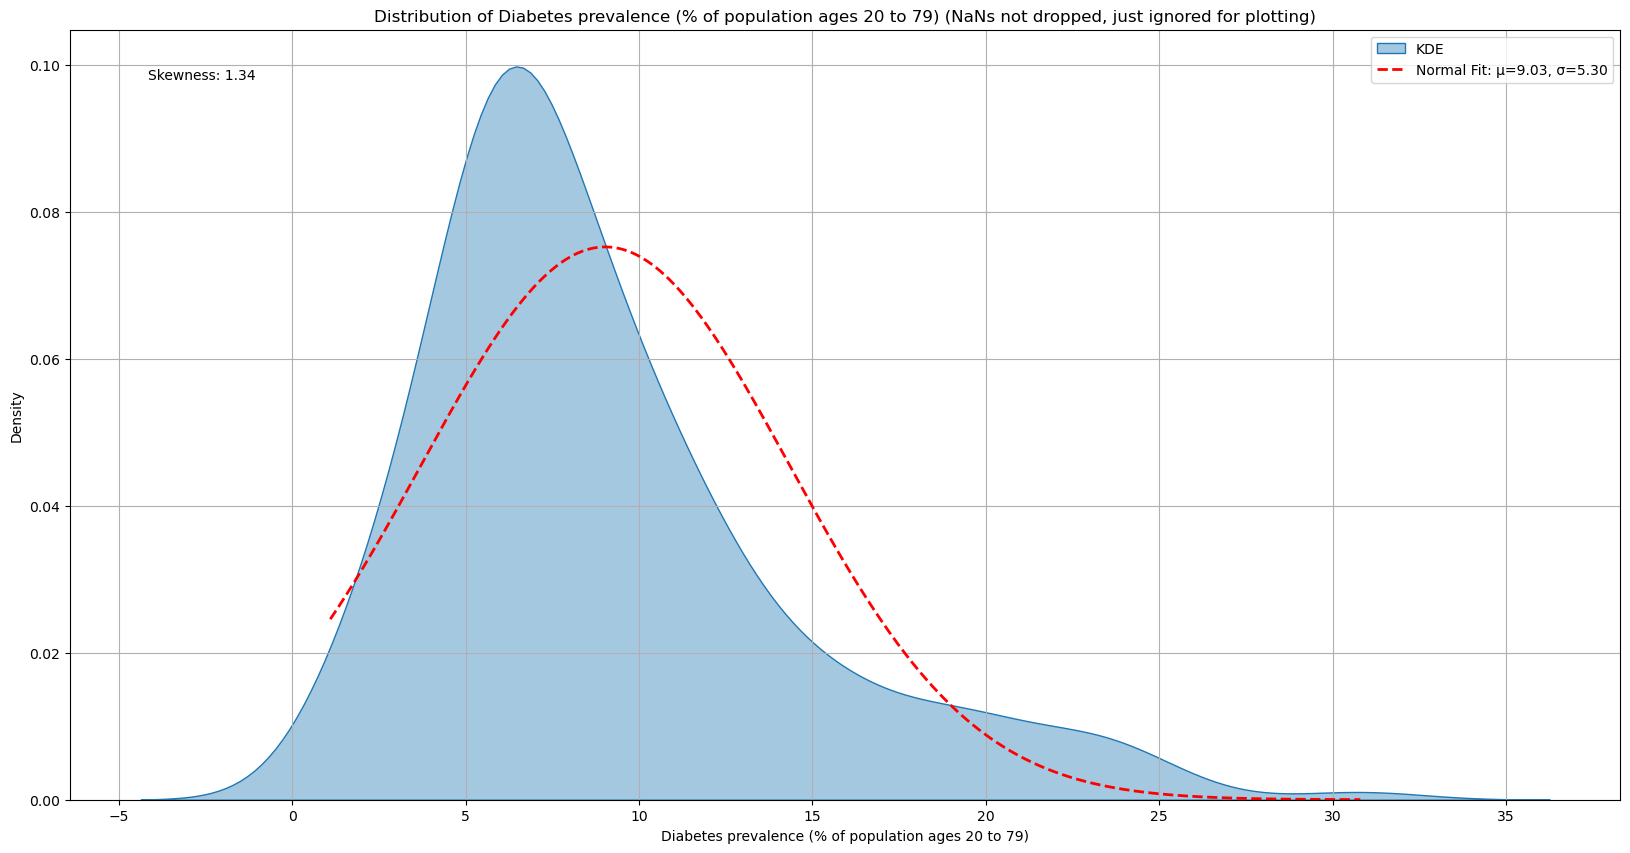

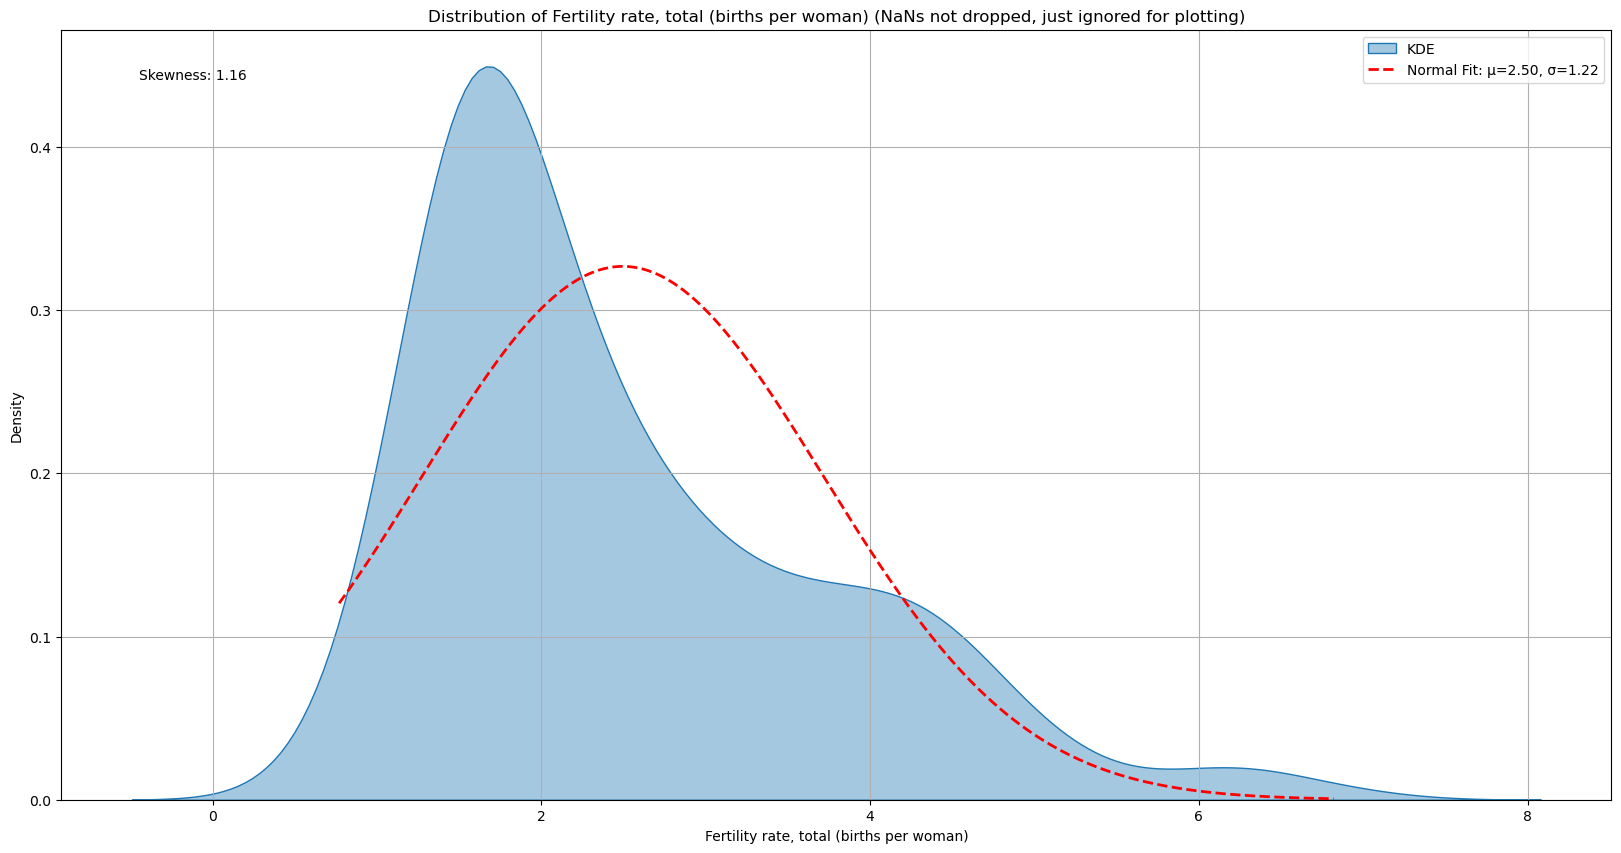

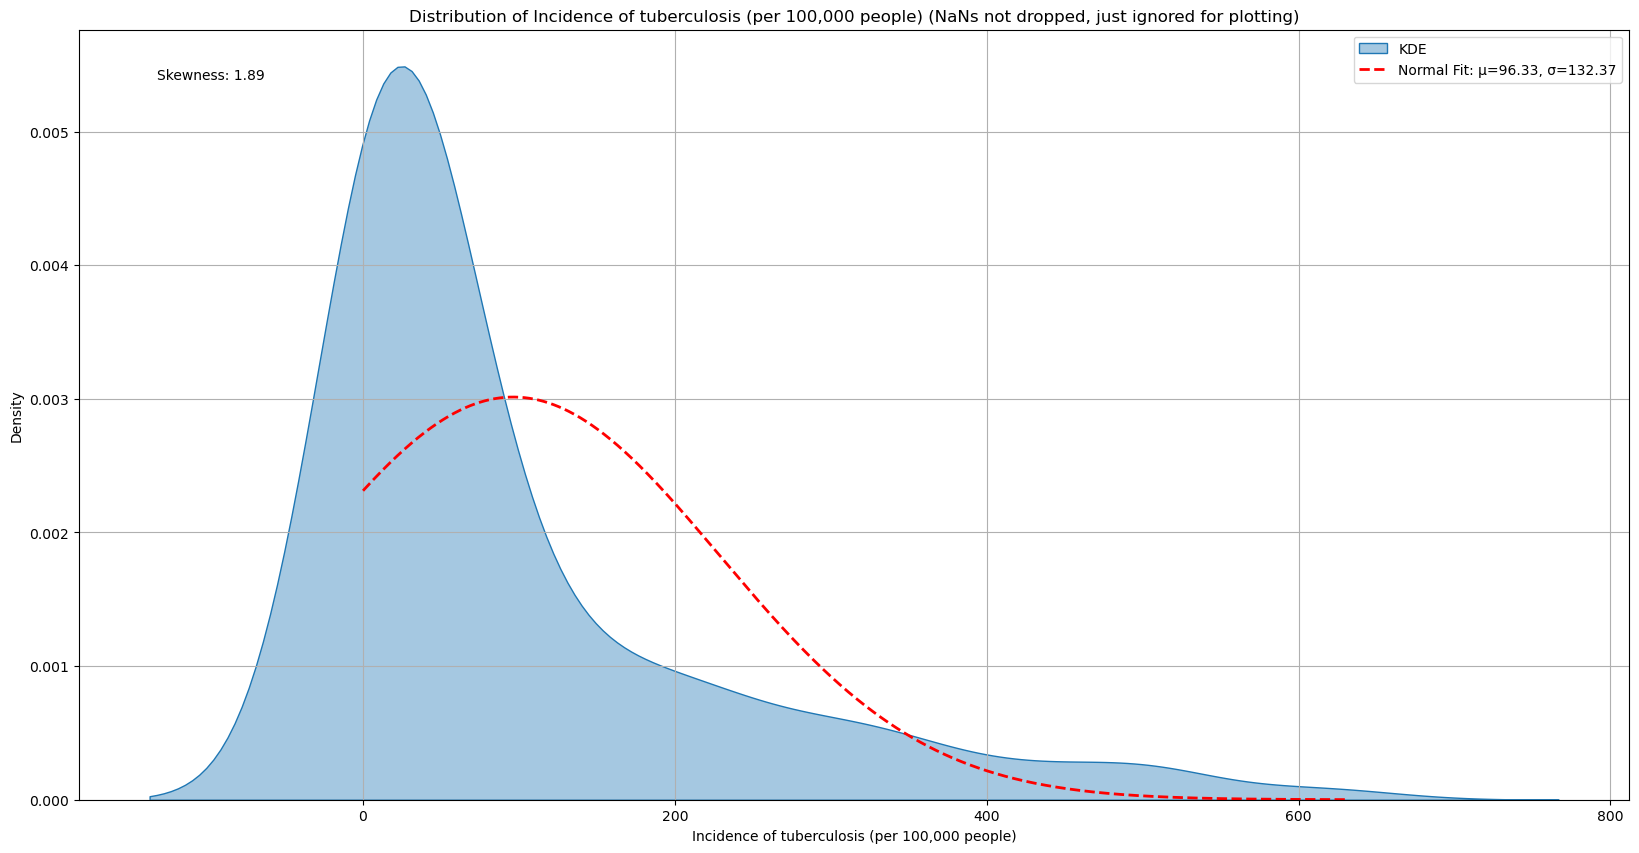

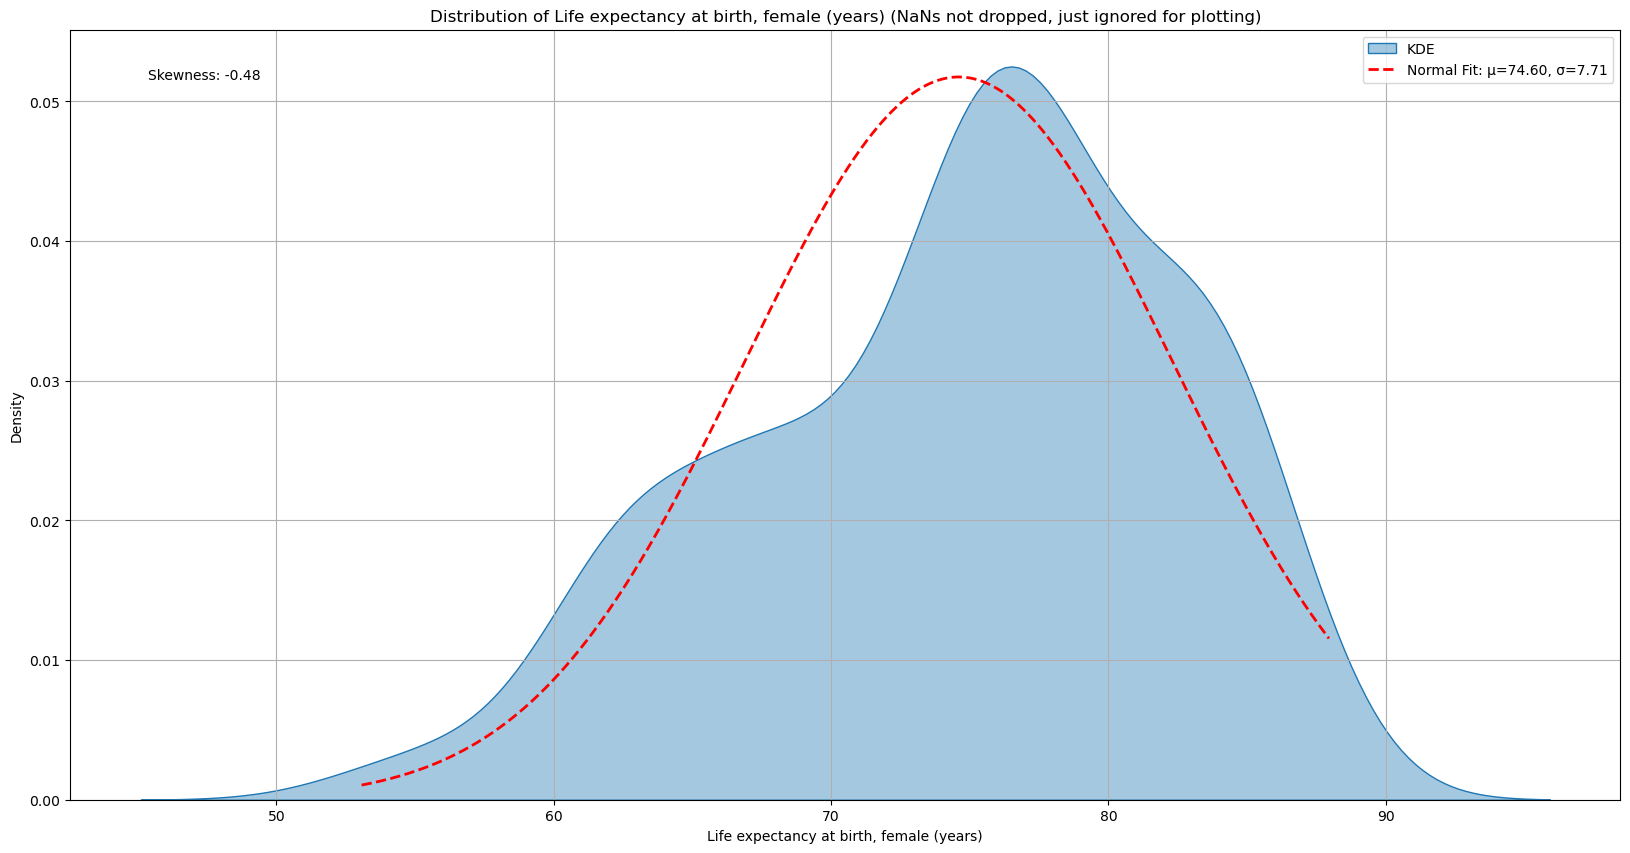

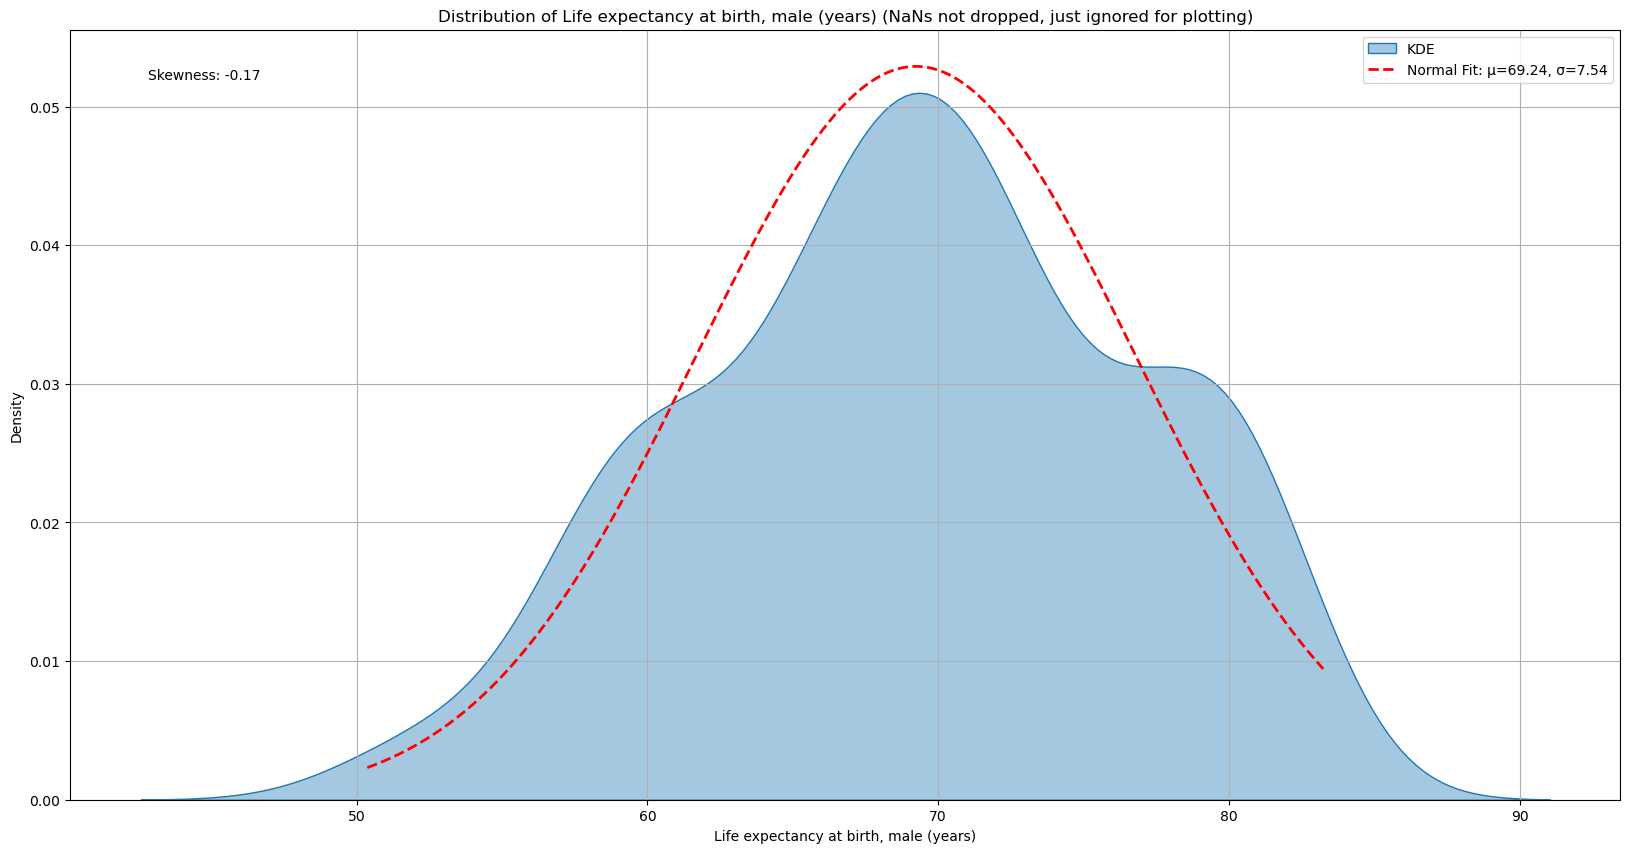

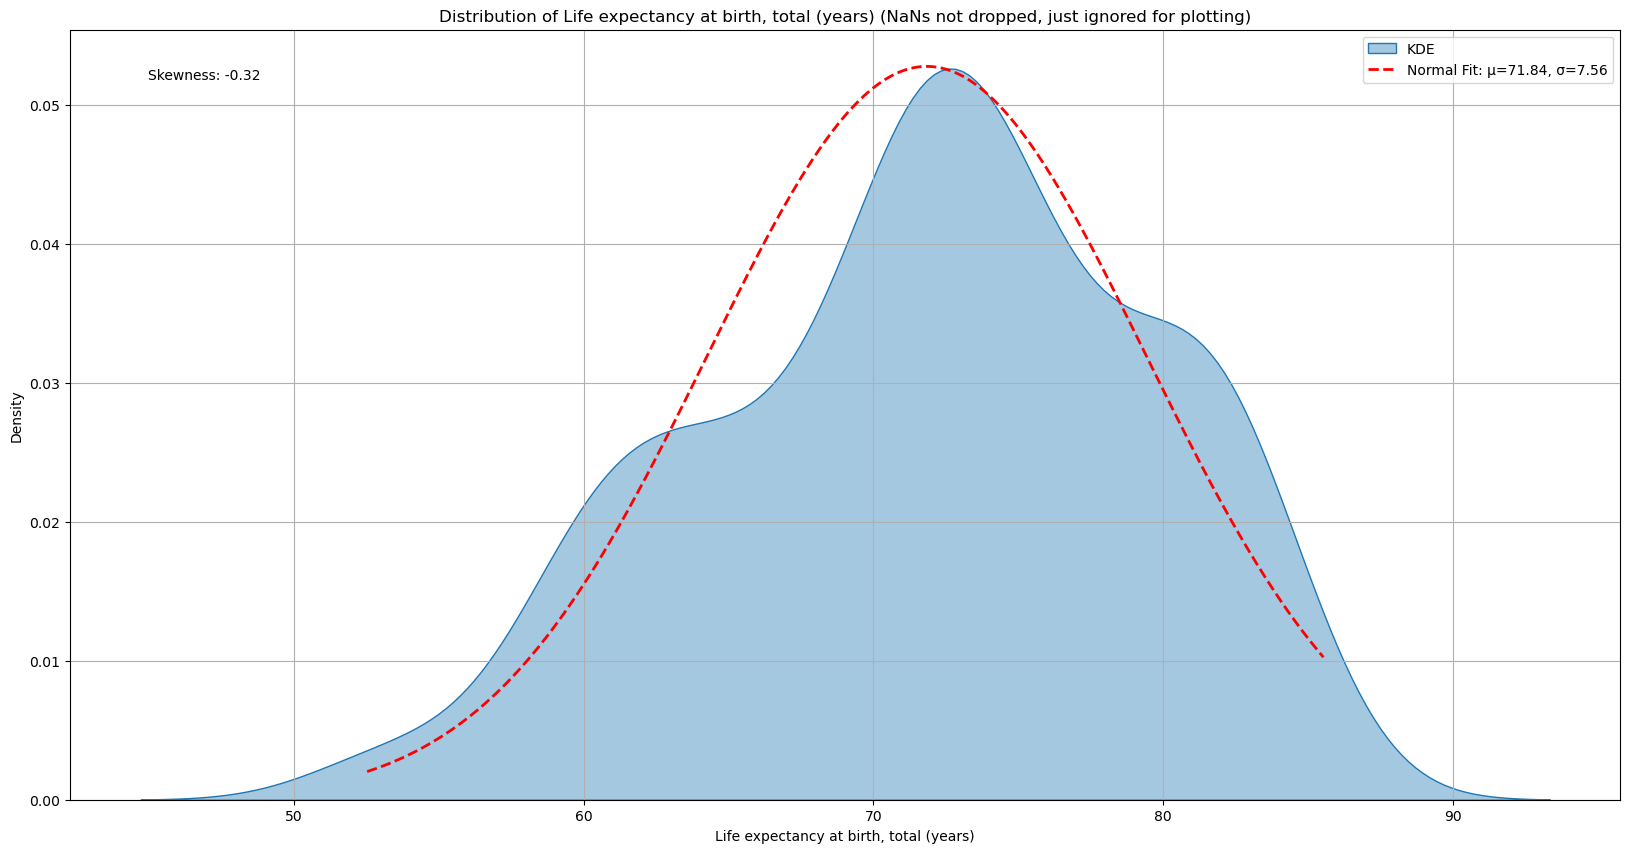

In [21]:
# plot and show distribution of the target variable of 0-5% missing values columns
for column in zero_to_five_missing:
    target_variable_distribution_plot(df_without_missing, column)


In [22]:
# fill missing values with mean or median for columns with 0-5% missing values
for column in zero_to_five_missing:
    if check_skewness(df_without_missing, column)[0]:
        df_without_missing.loc[:, column] = df_without_missing[column].fillna(df_without_missing[column].median())
    else:
        df_without_missing.loc[:, column] = df_without_missing[column].fillna(df_without_missing[column].mean())

In [23]:
# show data after filling missing values for columns with 0-5% missing values
df_without_missing[zero_to_five_missing].head()

Agricultural land (% of land area)  Arable land (% of land area)  \
0                               58.74                         12.00   
1                               41.47                         21.89   
2                               17.35                          3.16   
3                               14.50                          4.85   
4                               39.91                          1.59   

   Forest area (% of land area)  Forest area (sq. km)  Land area (sq. km)  \
0                          1.85              12084.40            652230.0   
1                         28.79               7889.00             27400.0   
2                          0.82              19583.33           2381741.0   
3                         85.50                171.00               200.0   
4                         34.04                160.00               470.0   

   Rural population  Rural population (% of total population)  \
0        29547690.0                                     73.69   
1         1041188.0                                     37.03   
2        11370967.0                                     25.74   
3            5778.0                                     12.83   
4            9596.0                                     12.14   

   Surface area (sq. km)  Access to electricity (% of population)  \
0               652860.0                                     97.7   
1                28750.0                                    100.0   
2              2381741.0                                     99.8   
3                  200.0                                    100.0   
4                  470.0                                    100.0   

   Renewable energy consumption (% of total final energy consumption)  ...  \
0                                               20.0                   ...   
1                                               41.9                   ...   
2                                                0.1                   ...   
3                                                0.4                   ...   
4                                               18.4                   ...   

   Mobile cellular subscriptions (per 100 people)  \
0                                           56.55   
1                                           92.32   
2                                          106.42   
3                                          111.96   
4                                          118.67   

   Secure Internet servers (per 1 million people)  \
0                                           39.03   
1                                          988.03   
2                                           62.93   
3                                          466.30   
4                                        11185.06   

   Birth rate, crude (per 1,000 people)  Death rate, crude (per 1,000 people)  \
0                                35.840                                  7.34   
1                                10.240                                 11.33   
2                                21.520                                  4.55   
3                                15.145                                  8.13   
4                                15.145                                  8.13   

   Diabetes prevalence (% of population ages 20 to 79)  \
0                                               10.9     
1                                               10.2     
2                                                7.1     
3                                               20.3     
4                                                9.7     

   Fertility rate, total (births per woman)  \
0                                      4.64   
1                                      1.39   
2                                      2.89   
3                                      2.03   
4                                      2.03   

   Incidence of tuberculosis (per 100,000 people)  \
0                           

### Handle 5-15% missing values

In [24]:
# show columns with 5-15% missing values
print("The total columns with 5-15% missing values:", len(five_to_fifteen_missing))
print("Columns with 5-15% missing values:")
for column in five_to_fifteen_missing:
    print(column)

The total columns with 5-15% missing values: 29
Columns with 5-15% missing values:
Agriculture, forestry, and fishing, value added (% of GDP)
Crop production index (2014-2016 = 100)
Fertilizer consumption (kilograms per hectare of arable land)
Food production index (2014-2016 = 100)
Livestock production index (2014-2016 = 100)
Permanent cropland (% of land area)
Mortality rate, under-5 (per 1,000 live births)
GNI per capita, PPP (current international $)
GNI, PPP (current international $)
Industry (including construction), value added (% of GDP)
Price level ratio of PPP conversion factor (GDP) to market exchange rate
Labor force, female (% of total labor force)
Labor force, total
Unemployment, total (% of total labor force) (modeled ILO estimate)
Energy intensity level of primary energy (MJ/$2017 PPP GDP)
Fixed broadband subscriptions (per 100 people)
Fixed telephone subscriptions (per 100 people)
Immunization, DPT (% of children ages 12-23 months)
Immunization, measles (% of children 

In [25]:
# show 5-15% missing values mean and median
for column in five_to_fifteen_missing:
    print(column, "=>", df_without_missing[column].mean(), df_without_missing[column].median())

Agriculture, forestry, and fishing, value added (% of GDP) => 9.999947643979057 6.56
Crop production index (2014-2016 = 100) => 108.04969072164948 104.94
Fertilizer consumption (kilograms per hectare of arable land) => 159.09673796791444 92.2
Food production index (2014-2016 = 100) => 108.72422680412372 105.58000000000001
Livestock production index (2014-2016 = 100) => 109.80461139896373 105.97
Permanent cropland (% of land area) => 4.502060301507538 1.63
Mortality rate, under-5 (per 1,000 live births) => 25.560512820512823 15.4
GNI per capita, PPP (current international $) => 24673.333333333332 16040.0
GNI, PPP (current international $) => 780499825940.3257 70041413822.0
Industry (including construction), value added (% of GDP) => 25.82020618556701 24.14
Price level ratio of PPP conversion factor (GDP) to market exchange rate => 0.5359798994974874 0.44
Labor force, female (% of total labor force) => 41.60720430107527 44.875
Labor force, total => 18821420.580645163 4154629.0
Unemployme

In [26]:
# impute with KNN imputer for columns with 5-15% missing values
for column in five_to_fifteen_missing:
    df_without_missing.loc[:, column] = knn_impute_selected_columns(df_without_missing, column,n_neighbors=5)

In [27]:
# show data after filling missing values for columns with 5-15% missing values
df_without_missing[five_to_fifteen_missing].head()

Agriculture, forestry, and fishing, value added (% of GDP)  \
0                                             33.600            
1                                             18.360            
2                                             11.230            
3                                              7.622            
4                                              0.530            

   Crop production index (2014-2016 = 100)  \
0                                  125.670   
1                                  114.680   
2                                  108.760   
3                                   93.424   
4                                   95.858   

   Fertilizer consumption (kilograms per hectare of arable land)  \
0                                              5.200               
1                                             78.464               
2                                             20.680               
3                                             75.072               
4                                             86.572               

   Food production index (2014-2016 = 100)  \
0                                  114.320   
1                                  104.920   
2                                  104.830   
3                                   94.110   
4                                   94.402   

   Livestock production index (2014-2016 = 100)  \
0                                        96.070   
1                                        91.790   
2                                        97.320   
3                                        98.518   
4                                        95.502   

   Permanent cropland (% of land area)  \
0                                 0.34   
1                                 3.20   
2                                 0.41   
3                                 9.65   
4                                 0.02   

   Mortality rate, under-5 (per 1,000 live births)  \
0                                            59.60   
1                                             9.50   
2                                            22.30   
3                                            13.76   
4                                             2.80   

   GNI per capita, PPP (current international $)  \
0                                         2150.0   
1                                        16040.0   
2                                        14400.0   
3                                        11844.0   
4                                        63290.0   

   GNI, PPP (current international $)  \
0                        8.628536e+10   
1                        4.508629e+10   
2                        6.360000e+11   
3                        1.320712e+09   
4                        5.001856e+09   

   Industry (including construction), value added (% of GDP)  ...  \
0                                             14.270          ...   
1                                             20.750          ...   
2                                             36.320          ...   
3                                             13.532          ...   
4                                             12.370          ...   

   Proportion of seats held by women in national parliaments (%)  \
0                                             27.020               
1                                             35.710               
2                                              8.110               
3                                             19.538               
4                                             46.430               

   Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)  \
0                                              14.79                                                 
1                                              51.79                                                 
2                                              16.00                      

### Handle 15-30% missing values

In [28]:
# show columns with 15-30% missing values
print("The total columns with 15-30% missing values:", len(fifteen_to_thirty_missing))
print("Columns with 15-30% missing values:")
for column in fifteen_to_thirty_missing:
    print(column)

The total columns with 15-30% missing values: 16
Columns with 15-30% missing values:
Cereal yield (kg per hectare)
Annual freshwater withdrawals, total (% of internal resources)
Current account balance (BoP, current US$)
Exports of goods and services (% of GDP)
Gross savings (% of GDP)
Imports of goods and services (% of GDP)
Inflation, consumer prices (annual %)
Total reserves (includes gold, current US$)
Government expenditure on education, total (% of GDP)
School enrollment, primary (% gross)
Renewable internal freshwater resources, total (billion cubic meters)
Air transport, registered carrier departures worldwide
Prevalence of undernourishment (% of population)
Fuel exports (% of merchandise exports)
High-technology exports (% of manufactured exports)
High-technology exports (current US$)


In [29]:
# show 15-30% missing values mean and median
for column in fifteen_to_thirty_missing:
    print(column, "=>", df_without_missing[column].mean(), df_without_missing[column].median())

Cereal yield (kg per hectare) => 3809.825280898876 3062.55
Annual freshwater withdrawals, total (% of internal resources) => 128.8342613636364 9.245000000000001
Current account balance (BoP, current US$) => 3694672239.101621 -319279309.5
Exports of goods and services (% of GDP) => 43.04966101694915 34.89
Gross savings (% of GDP) => 23.118961038961036 22.195
Imports of goods and services (% of GDP) => 49.157231638418075 42.61
Inflation, consumer prices (annual %) => 8.570352941176472 3.4450000000000003
Total reserves (includes gold, current US$) => 92438571586.31688 8424740406.0
Government expenditure on education, total (% of GDP) => 4.486463414634146 4.255
School enrollment, primary (% gross) => 100.45940476190476 99.91
Renewable internal freshwater resources, total (billion cubic meters) => 234.43747252747255 32.15
Air transport, registered carrier departures worldwide => 155190.89606451613 15844.0
Prevalence of undernourishment (% of population) => 10.605882352941176 5.2
Fuel export

In [30]:
# impute with linear regression for columns with 15-30% missing values
for column in fifteen_to_thirty_missing:
    df_without_missing.loc[:, column] = linear_regression_impute(df_without_missing, column)

In [31]:
# show data after filling missing values for columns with 15-30% missing values
df_without_missing[fifteen_to_thirty_missing].head()

Cereal yield (kg per hectare)  \
0                    2099.000000   
1                    5144.700000   
2                    1433.700000   
3                    -659.630444   
4                    6123.170679   

   Annual freshwater withdrawals, total (% of internal resources)  \
0                                          43.020000                
1                                           2.960000                
2                                          87.150000                
3                                         753.115800                
4                                       -1830.494394                

   Current account balance (BoP, current US$)  \
0                                1.831602e+10   
1                               -1.369695e+09   
2                               -4.509654e+09   
3                               -2.091003e+10   
4                                4.674353e+08   

   Exports of goods and services (% of GDP)  Gross savings (% of GDP)  \
0                                 14.340000                 20.971528   
1                                 31.310000                 17.150000   
2                                 23.880000                 38.670000   
3                                 44.270000                 17.168192   
4                                 95.741365                 16.599939   

   Imports of goods and services (% of GDP)  \
0                                  37.07000   
1                                  44.71000   
2                                  23.39000   
3                                  92.53000   
4                                  72.22962   

   Inflation, consumer prices (annual %)  \
0                              79.821331   
1                               2.040000   
2                               7.230000   
3                              41.649573   
4                             216.150559   

   Total reserves (includes gold, current US$)  \
0                                -3.887262e+11   
1                                 5.634561e+09   
2                                 5.621101e+10   
3                                -1.428677e+11   
4                                 2.734048e+11   

   Government expenditure on education, total (% of GDP)  \
0                                           3.657242       
1                                           3.020000       
2                                           5.510000       
3                                           6.100001       
4                                           2.580000       

   School enrollment, primary (% gross)  \
0                            212.163708   
1                             97.110000   
2                            107.000000   
3                            109.266233   
4                             88.880000   

   Renewable internal freshwater resources, total (billion cubic meters)  \
0                                          47.150000                       
1                                          26.900000                       
2                                          11.250000                       
3                                        -214.383055                       
4                                           0.320000                       

   Air transport, registered carrier departures worldwide  \
0                                        2865.740000        
1                                        1471.000000        
2                                       27650.000000        
3                                       40039.380281        
4                                      106897.241545        

   Prevalence of undernourishment (% of population)  \
0                                         30.100000   
1                                          4.100000   
2                                          2.500000   
3                                          0.452183   
4                                          7.883378   

   Fuel expor

### Handle 30%> missing values

In [32]:
# show columns with 30-50% missing values
print("The total columns with 30-50% missing values:", len(thirty_to_fifty_missing))
print("Columns with 30-50% missing values:")
for column in thirty_to_fifty_missing:
    print(column)

The total columns with 30-50% missing values: 24
Columns with 30-50% missing values:
Population in urban agglomerations of more than 1 million (% of total population)
Primary completion rate, total (% of relevant age group)
Adjusted net savings, including particulate emission damage (% of GNI)
Expense (% of GDP)
External debt stocks (% of GNI)
External debt stocks, total (DOD, current US$)
Grants, excluding technical cooperation (BoP, current US$)
Medium and high-tech manufacturing value added (% manufacturing value added)
Net ODA received (% of GNI)
Net ODA received per capita (current US$)
Net official development assistance received (current US$)
Revenue, excluding grants (% of GDP)
Technical cooperation grants (BoP, current US$)
Total debt service (% of exports of goods, services and primary income)
School enrollment, secondary (% gross)
School enrollment, tertiary (% gross)
Prevalence of HIV, total (% of population ages 15-49)
Risk of catastrophic expenditure for surgical care (% 

In [33]:
# show 30-50% missing values mean and median
for column in thirty_to_fifty_missing:
    print(column, "=>", df_without_missing[column].mean(), df_without_missing[column].median())

Population in urban agglomerations of more than 1 million (% of total population) => 26.50826446280992 21.72
Primary completion rate, total (% of relevant age group) => 93.57798507462687 97.09
Adjusted net savings, including particulate emission damage (% of GNI) => 7.8493220338983045 8.385
Expense (% of GDP) => 24.67848739495798 24.83
External debt stocks (% of GNI) => 62.21781512605042 51.52
External debt stocks, total (DOD, current US$) => 77601078011.73361 13759708513.0
Grants, excluding technical cooperation (BoP, current US$) => 691005955.882353 258655000.0
Medium and high-tech manufacturing value added (% manufacturing value added) => 24.740132450331124 22.42
Net ODA received (% of GNI) => 6.7306923076923075 3.265
Net ODA received per capita (current US$) => 213.89860294117648 60.85
Net official development assistance received (current US$) => 988318968.7452207 480160003.65
Revenue, excluding grants (% of GDP) => 21.71075 20.955
Technical cooperation grants (BoP, current US$) =>

In [34]:
# show columns
list(df_without_missing.columns)


['Country Name',
 'Year',
 'Agricultural land (% of land area)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Arable land (% of land area)',
 'Cereal yield (kg per hectare)',
 'Crop production index (2014-2016 = 100)',
 'Fertilizer consumption (kilograms per hectare of arable land)',
 'Food production index (2014-2016 = 100)',
 'Forest area (% of land area)',
 'Forest area (sq. km)',
 'Land area (sq. km)',
 'Livestock production index (2014-2016 = 100)',
 'Permanent cropland (% of land area)',
 'Rural population',
 'Rural population (% of total population)',
 'Surface area (sq. km)',
 'Access to electricity (% of population)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Population, total',
 'Primary completion rate, total (% of relevant age group)',
 'Renewable energy consu

In [35]:
# For each column with high missingness, call the function:
for column in thirty_to_fifty_missing:
    df_without_missing.loc[:, column] = mice_impute_single_column(
        df_without_missing, 
        column, 
        random_state=42,
        max_iter=10
    )

In [36]:
# show data after filling missing values for columns with 30-50% missing values
df_without_missing[thirty_to_fifty_missing].head()

Population in urban agglomerations of more than 1 million (% of total population)  \
0                                          10.810000                                   
1                                          22.434678                                   
2                                           6.360000                                   
3                                          16.184536                                   
4                                          49.717850                                   

   Primary completion rate, total (% of relevant age group)  \
0                                          81.176591          
1                                          97.220000          
2                                          99.750000          
3                                          90.641430          
4                                          62.070000          

   Adjusted net savings, including particulate emission damage (% of GNI)  \
0                                         -50.434286                        
1                                           3.070000                        
2                                          15.400000                        
3                                          15.382161                        
4                                          11.704600                        

   Expense (% of GDP)  External debt stocks (% of GNI)  \
0           44.544615                        24.770000   
1           18.920000                        62.520000   
2           30.817961                         4.600000   
3           30.582875                        95.181985   
4           22.834676                        74.278639   

   External debt stocks, total (DOD, current US$)  \
0                                    3.555784e+09   
1                                    1.105488e+10   
2                                    7.378779e+09   
3                                    4.858470e+10   
4                                   -3.388808e+09   

   Grants, excluding technical cooperation (BoP, current US$)  \
0                                       4.329130e+09            
1                                       2.641200e+08            
2                                       1.126000e+08            
3                                       6.233350e+08            
4                                       6.043356e+08            

   Medium and high-tech manufacturing value added (% manufacturing value added)  \
0                                           8.460000                              
1                                           6.310000                              
2                                           2.690000                              
3                                          10.619769                              
4                                          33.826977                              

   Net ODA received (% of GNI)  Net ODA received per capita (current US$)  \
0                    32.680000                                 116.970000   
1                     3.580000                                 225.280000   
2                     0.120000                                   4.850000   
3                     1.387106                                 277.871062   
4                   -13.244878                                 219.398904   

   ...  School enrollment, secondary (% gross)  \
0  ...                               55.070408   
1  ...                               97.670000   
2  ...                               97.170771   
3  ...                               79.596104   
4  ...                               97.330000   

   School enrollment, tertiary (% gross)  \
0                              24.454886   
1                              59.970000   
2                              54.210000   
3                              43.006242   
4                              15.200000   

   Prevalence of HIV, total (% of population 

## Check if there are missing values

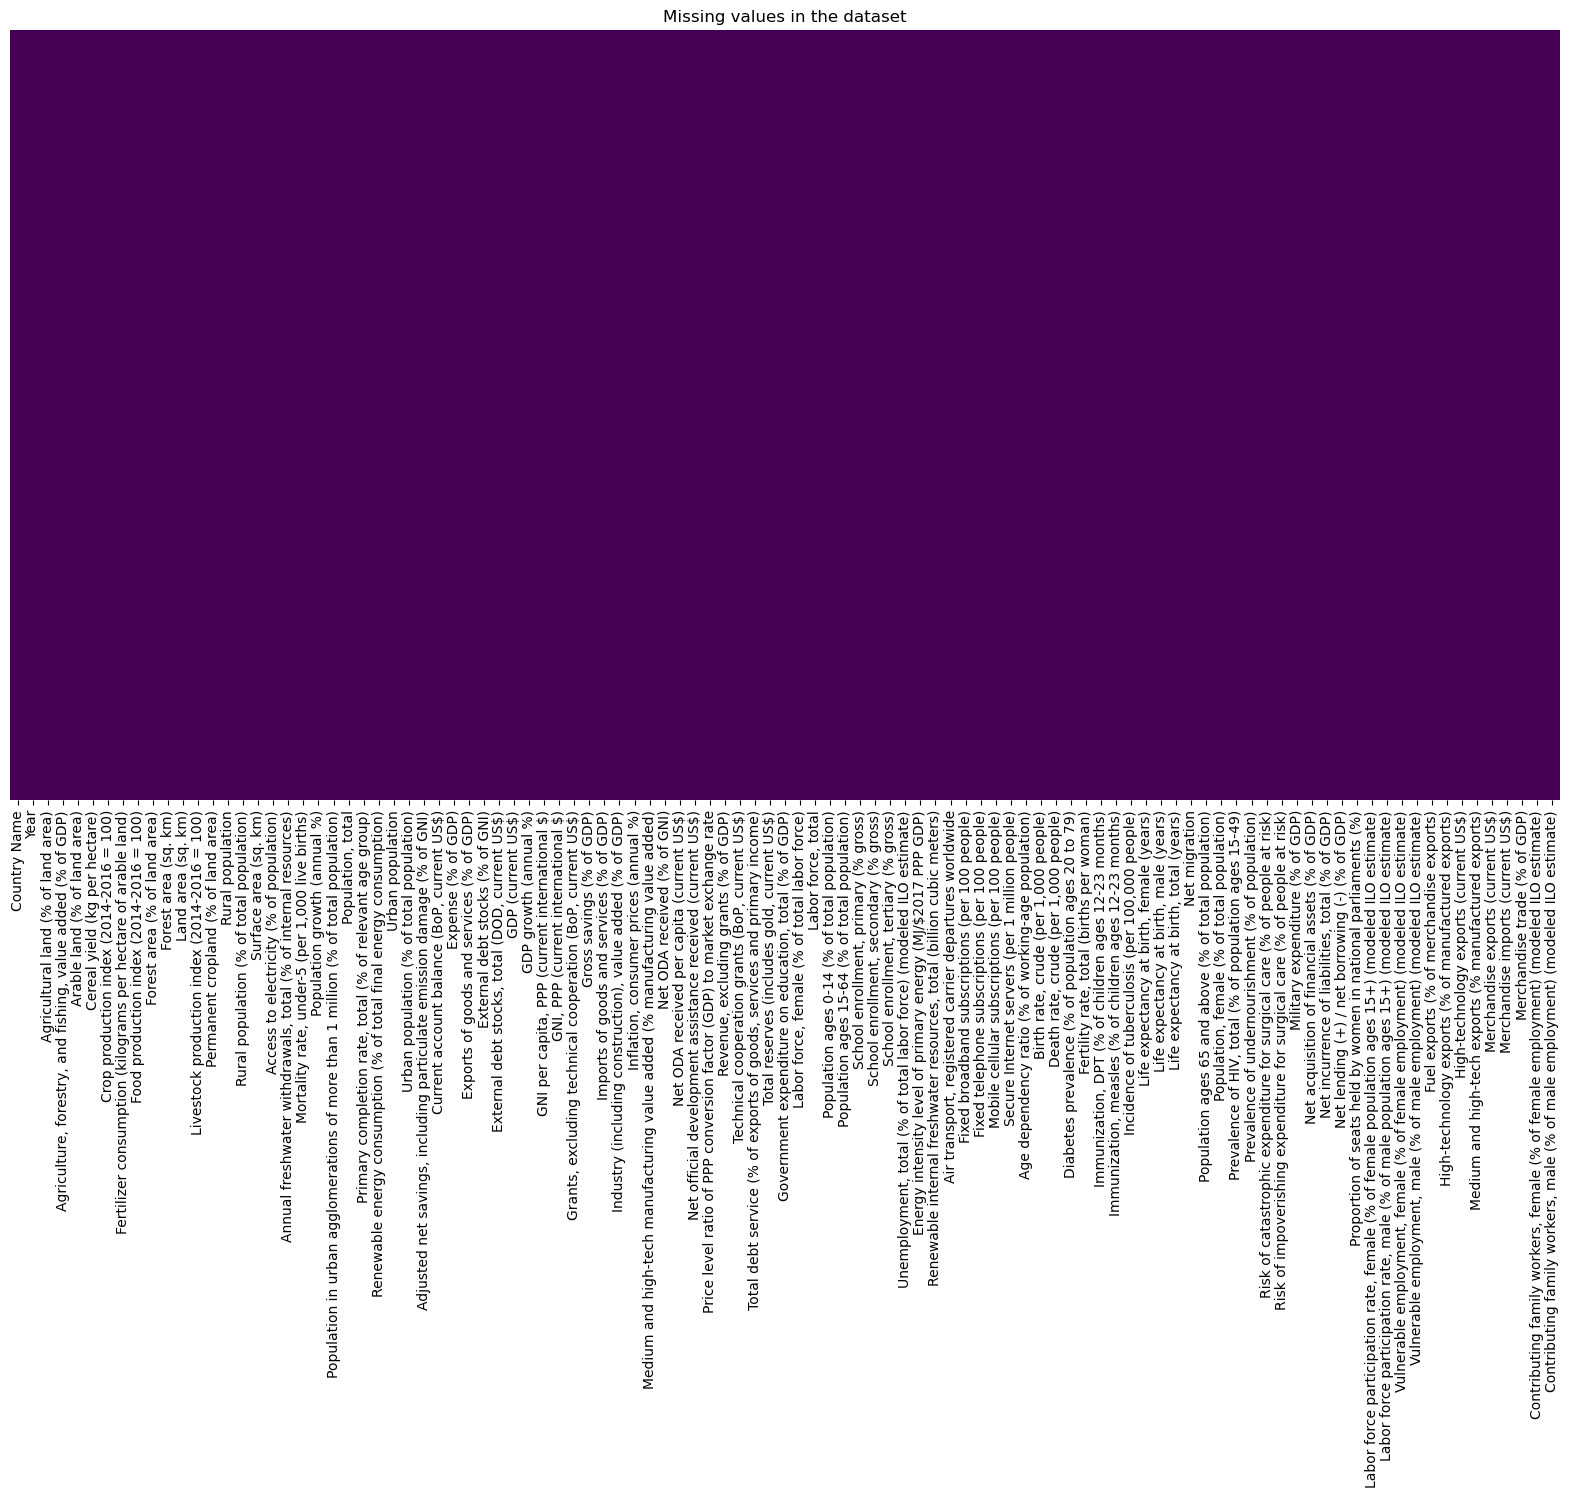

In [37]:
# check missing values after filling missing values
missing_values_plot(df_without_missing)

# Features Selection

Our goal is Social and Demographic Clustering. We want to focus on variables that capture population characteristics, age distribution, education, and overall health or well-being.

In [38]:
# show all columns
list(df_without_missing.columns)

['Country Name',
 'Year',
 'Agricultural land (% of land area)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Arable land (% of land area)',
 'Cereal yield (kg per hectare)',
 'Crop production index (2014-2016 = 100)',
 'Fertilizer consumption (kilograms per hectare of arable land)',
 'Food production index (2014-2016 = 100)',
 'Forest area (% of land area)',
 'Forest area (sq. km)',
 'Land area (sq. km)',
 'Livestock production index (2014-2016 = 100)',
 'Permanent cropland (% of land area)',
 'Rural population',
 'Rural population (% of total population)',
 'Surface area (sq. km)',
 'Access to electricity (% of population)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Population, total',
 'Primary completion rate, total (% of relevant age group)',
 'Renewable energy consu

In [39]:
# Select features
features = [
    'Population, total', 
    'Population growth (annual %)',
    'Rural population',
    'Rural population (% of total population)',
    'Urban population',
    'Urban population (% of total population)',
    'Population ages 0-14 (% of total population)',
    'Population ages 15-64 (% of total population)',
    'Population ages 65 and above (% of total population)',
    'School enrollment, primary (% gross)',
    'School enrollment, secondary (% gross)',
    'School enrollment, tertiary (% gross)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'Life expectancy at birth, female (years)',
    'Life expectancy at birth, male (years)',
    'Life expectancy at birth, total (years)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)'
]

In [40]:
# show data after filling missing values for selected features
df_without_missing[features].head()

Population, total  Population growth (annual %)  Rural population  \
0         40099462.0                          2.85        29547690.0   
1          2811666.0                         -0.93         1041188.0   
2         44177969.0                          1.66        11370967.0   
3            45035.0                         -2.53            5778.0   
4            79034.0                          1.70            9596.0   

   Rural population (% of total population)  Urban population  \
0                                     73.69        10551772.0   
1                                     37.03         1770478.0   
2                                     25.74        32807002.0   
3                                     12.83           39257.0   
4                                     12.14           69438.0   

   Urban population (% of total population)  \
0                                     26.31   
1                                     62.97   
2                                     74.26   
3                                     87.17   
4                                     87.86   

   Population ages 0-14 (% of total population)  \
0                                         43.42   
1                                         16.28   
2                                         30.71   
3                                         27.51   
4                                         13.07   

   Population ages 15-64 (% of total population)  \
0                                          54.17   
1                                          67.48   
2                                          63.11   
3                                          65.64   
4                                          72.39   

   Population ages 65 and above (% of total population)  \
0                                               2.40      
1                                              16.23      
2                                               6.18      
3                                               6.84      
4                                              14.54      

   School enrollment, primary (% gross)  \
0                            212.163708   
1                             97.110000   
2                            107.000000   
3                            109.266233   
4                             88.880000   

   School enrollment, secondary (% gross)  \
0                               55.070408   
1                               97.670000   
2                               97.170771   
3                               79.596104   
4                               97.330000   

   School enrollment, tertiary (% gross)  \
0                              24.454886   
1                              59.970000   
2                              54.210000   
3                              43.006242   
4                              15.200000   

   Mortality rate, under-5 (per 1,000 live births)  \
0                                            59.60   
1                                             9.50   
2                                            22.30   
3                                            13.76   
4                                             2.80   

   Life expectancy at birth, female (years)  \
0                                 65.280000   
1                                 79.170000   
2                                 77.960000   
3                                 74.597656   
4                                 74.597656   

   Life expectancy at birth, male (years)  \
0                               58.920000   
1                               74.090000   
2                               74.880000   
3                               69.235502   
4                               69.235502   

   Life expectancy at birth, total (years)  \
0                                61.980000   
1                                76.460000   
2                                76.380000   
3                                71.840957   
4                

In [41]:
# drop some features to avoid redundancy
new_features = [
    'Population growth (annual %)',
    'Rural population (% of total population)',
    'Urban population (% of total population)',
    'Population ages 0-14 (% of total population)',
    'Population ages 15-64 (% of total population)',
    'Population ages 65 and above (% of total population)',
    'School enrollment, primary (% gross)',
    'School enrollment, secondary (% gross)',
    'School enrollment, tertiary (% gross)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'Life expectancy at birth, total (years)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)'
]

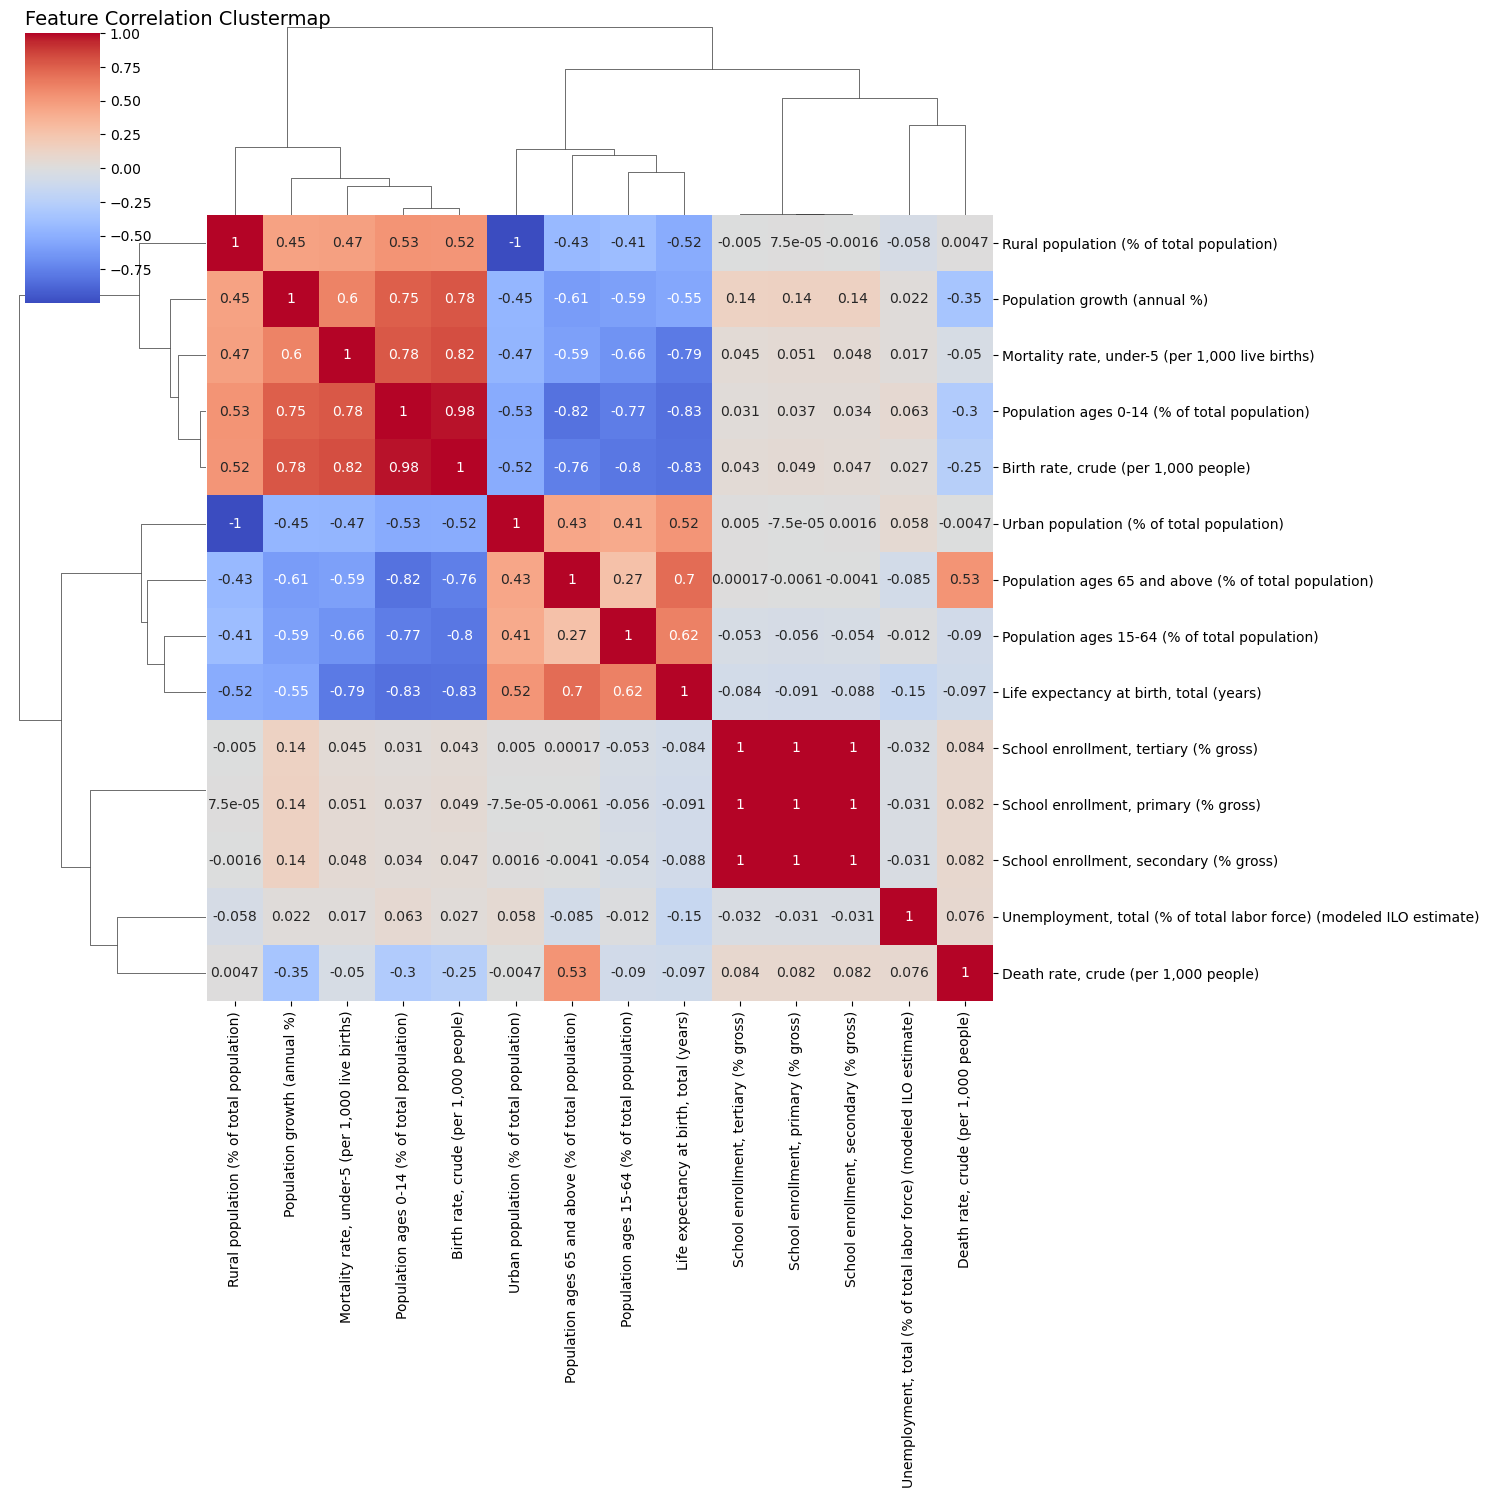

In [42]:
# Subset your DataFrame to these features
df_subset = df_without_missing[new_features]

# Compute the correlation matrix
corr_matrix = df_subset.corr()

# Visualize using a clustermap to see clusters of correlated features
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(15, 15))
plt.title("Feature Correlation Clustermap", loc='left', fontsize=14)
plt.show()

In [43]:
# remove some features which are correlated with other features

'''
🔴 Cluster 1: Rural % ↔ Urban % (Correlation: -1.00) -> keep Urban population (%) (more commonly used in social/demographic studies)

🔴 Cluster 2: Age Group Composition (naturally sum to ~100%) -> Keep only two max, or even just one if you're okay with a partial picture. 
                                                              -> Keep Population ages 0-14 (%) (youth indicator)
                                                              -> Keep Population ages 65+ (%) (aging indicator)
                                                              -> ❌ Drop 15-64 (%) (redundant with the other two)

🔴 Cluster 3: School Enrollment (moderate-to-high positive correlation (~0.67).) -> Keep one, or max two if educational level breakdown is important.
                                                                                  -> Keep School enrollment, tertiary (%) (better differentiator across development levels)
                                                                                  -> ❌ Drop Primary and possibly Secondary (more universal and less variance)
                                                                            
🟡 Birth & Death Rates vs. Under-5 Mortality (moderately correlated ) -> Keep them 

🟢 Standalone Features (No strong correlation with others) -> Keep them
'''

selected_features = [
    'Urban population (% of total population)',
    'Population growth (annual %)',
    'Population ages 0-14 (% of total population)',
    'Population ages 65 and above (% of total population)',
    'School enrollment, tertiary (% gross)',
    'Mortality rate, under-5 (per 1,000 live births)',
    'Life expectancy at birth, total (years)',
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)'
]


In [44]:
# show data after removing some features
df_selected_features = df_subset[selected_features]
df_selected_features

Urban population (% of total population)  Population growth (annual %)  \
0                                       26.31                          2.85   
1                                       62.97                         -0.93   
2                                       74.26                          1.66   
3                                       87.17                         -2.53   
4                                       87.86                          1.70   
..                                        ...                           ...   
211                                     96.04                         -0.40   
212                                     77.00                          2.46   
213                                     38.55                          2.14   
214                                     45.19                          2.84   
215                                     32.30                          2.05   

     Population ages 0-14 (% of total population)  \
0                                           43.42   
1                                           16.28   
2                                           30.71   
3                                           27.51   
4                                           13.07   
..                                            ...   
211                                         19.24   
212                                         39.14   
213                                         39.87   
214                                         43.26   
215                                         40.89   

     Population ages 65 and above (% of total population)  \
0                                                 2.40      
1                                                16.23      
2                                                 6.18      
3                                                 6.84      
4                                                14.54      
..                                                 ...      
211                                              20.00      
212                                               3.48      
213                                               2.69      
214                                               1.74      
215                                               3.36      

     School enrollment, tertiary (% gross)  \
0                                24.454886   
1                                59.970000   
2                                54.210000   
3                                43.006242   
4                                15.200000   
..                                     ...   
211                              44.409221   
212                              43.510000   
213                              55.384619   
214                              29.281854   
215                              33.019135   

     Mortality rate, under-5 (per 1,000 live births)  \
0                                              59.60   
1                                               9.50   
2                                              22.30   
3                                              13.76   
4                                               2.80   
..                                               ...   
211                                            49.04   
212                                            14.80   
213                                            44.60   
214                                            57.20   
215                                            49.10   

     Life expectancy at birth, total (years)  \
0                                  61.980000   
1                                  76.460000   
2                                  76.380000   
3                                  71.840957   
4                                  71.840957   
..                                       ...   
211                                80.070000   
212                                73.470000   
213                         

# Apply with hierarchical clustering

## Standard scaler

In [45]:
# apply with standard scaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected_features)

In [46]:
# # show dataset with scaler
df_scaled

array([[-1.50110414,  1.48848302,  1.6749841 , ...,  1.86645472,
        -0.4111474 ,  0.63896834],
       [ 0.04882778, -1.31404579, -0.9714469 , ..., -0.857474  ,
         0.79209643,  0.73500973],
       [ 0.5261527 ,  0.60620544,  0.4356275 , ...,  0.34275709,
        -1.25251339,  0.93776376],
       ...,
       [-0.98361459,  0.96208211,  1.32882234, ...,  1.30251635,
        -0.55891419,  1.76300825],
       [-0.70288497,  1.48106893,  1.65938244, ...,  1.72493811,
        -0.5227264 , -0.55799188],
       [-1.24785558,  0.89535523,  1.4282829 , ...,  1.30251635,
         0.10754418,  0.21389628]])

## Plot dendrogram

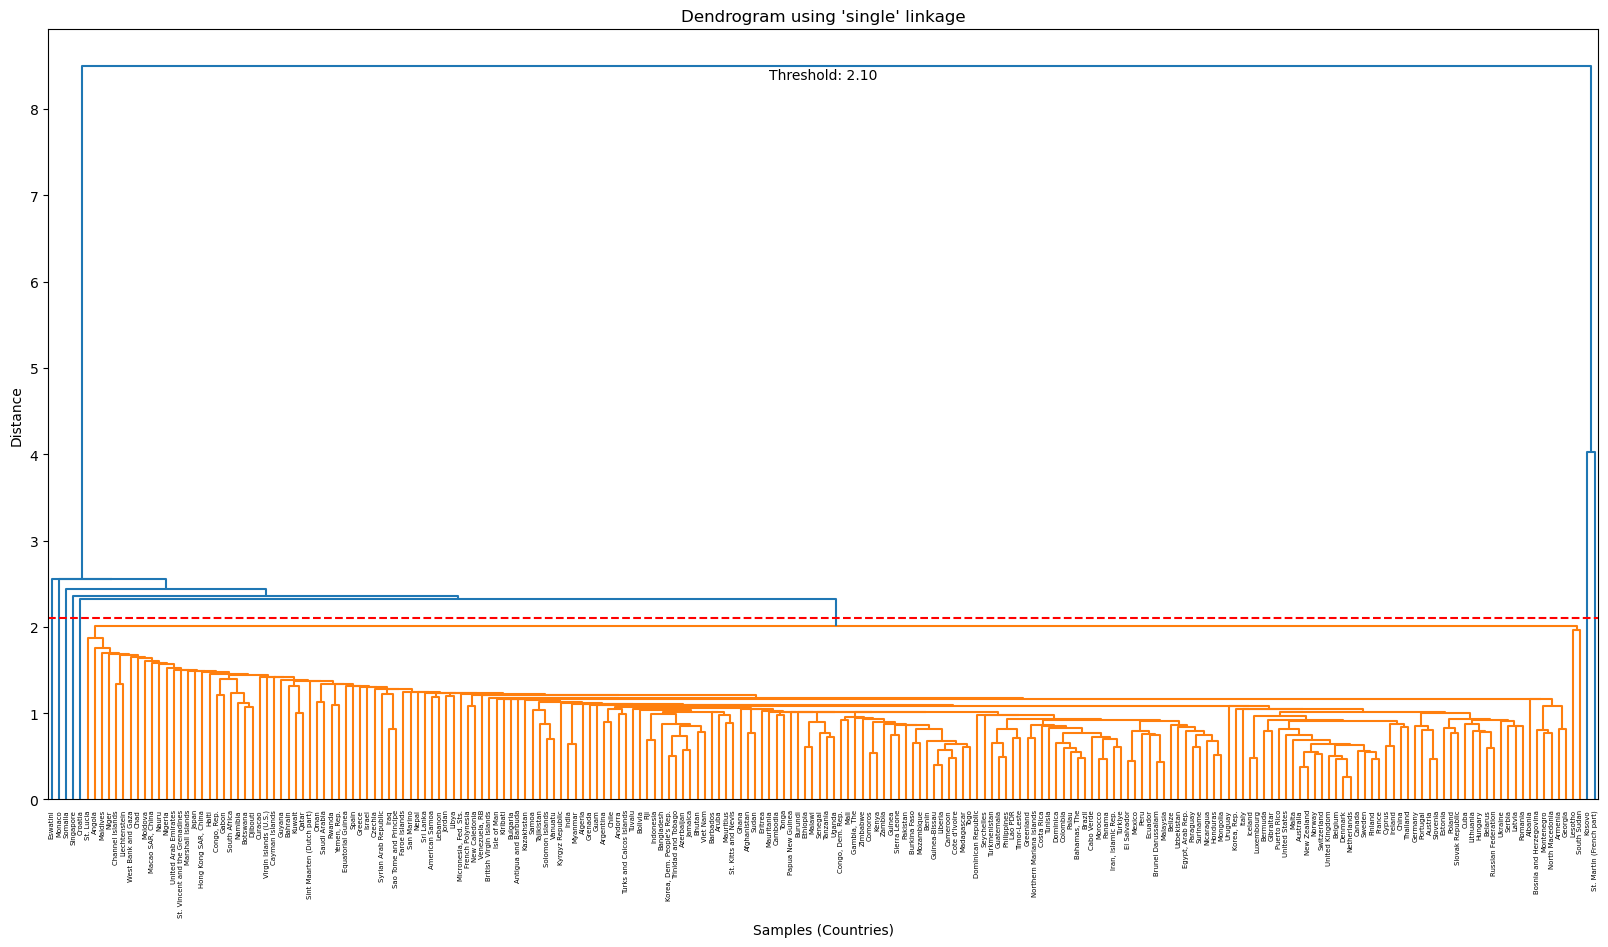

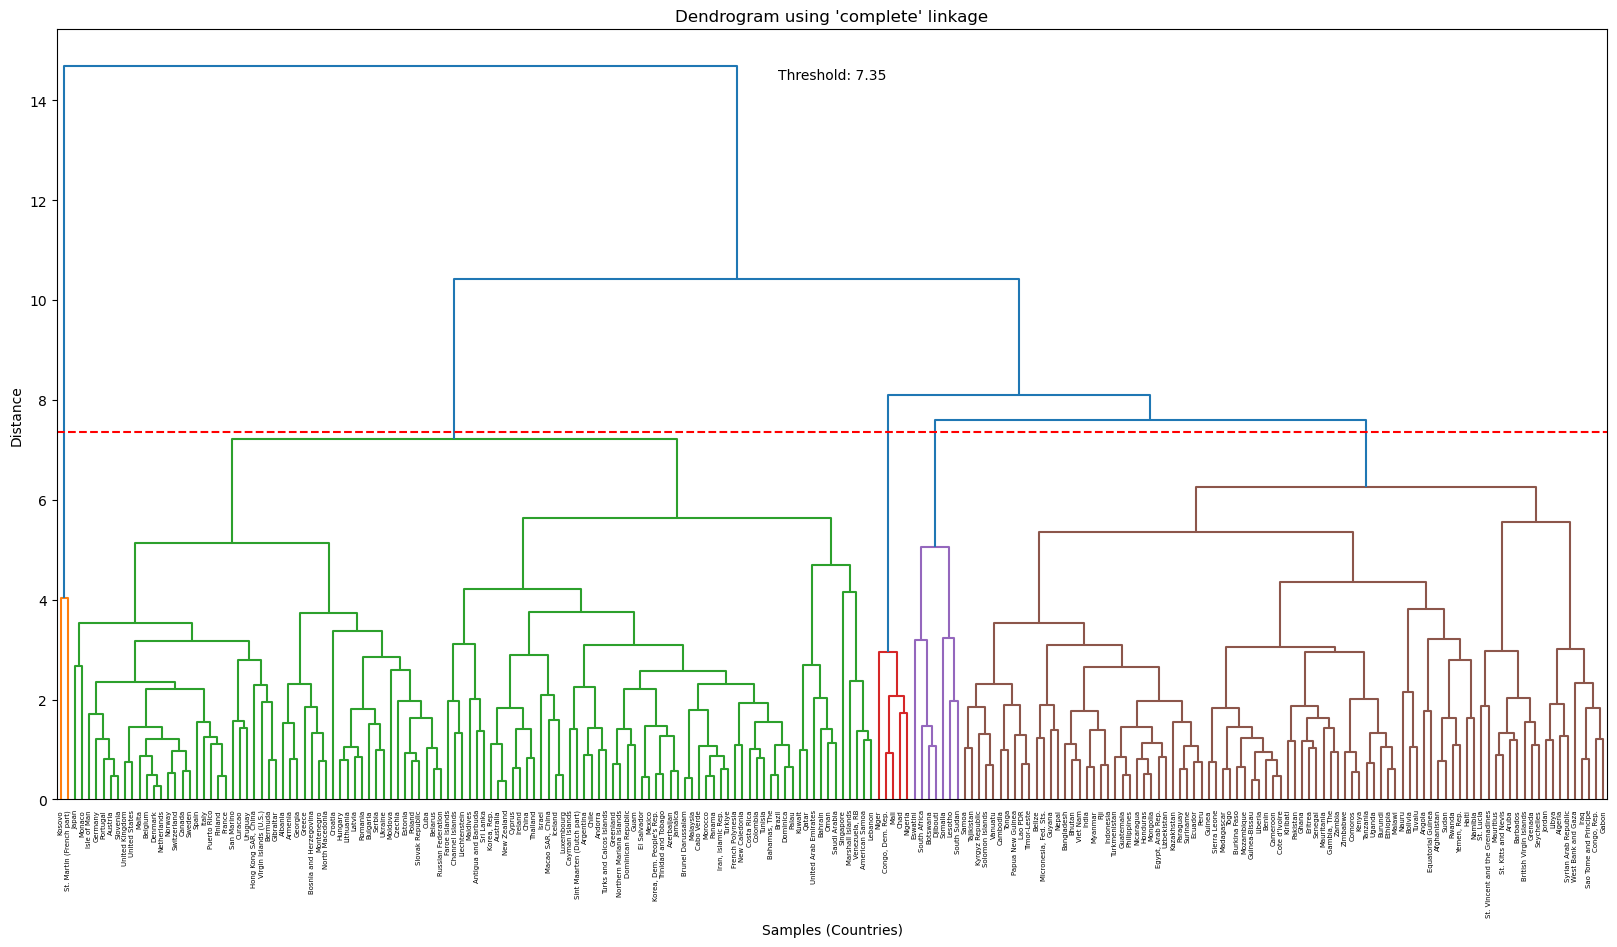

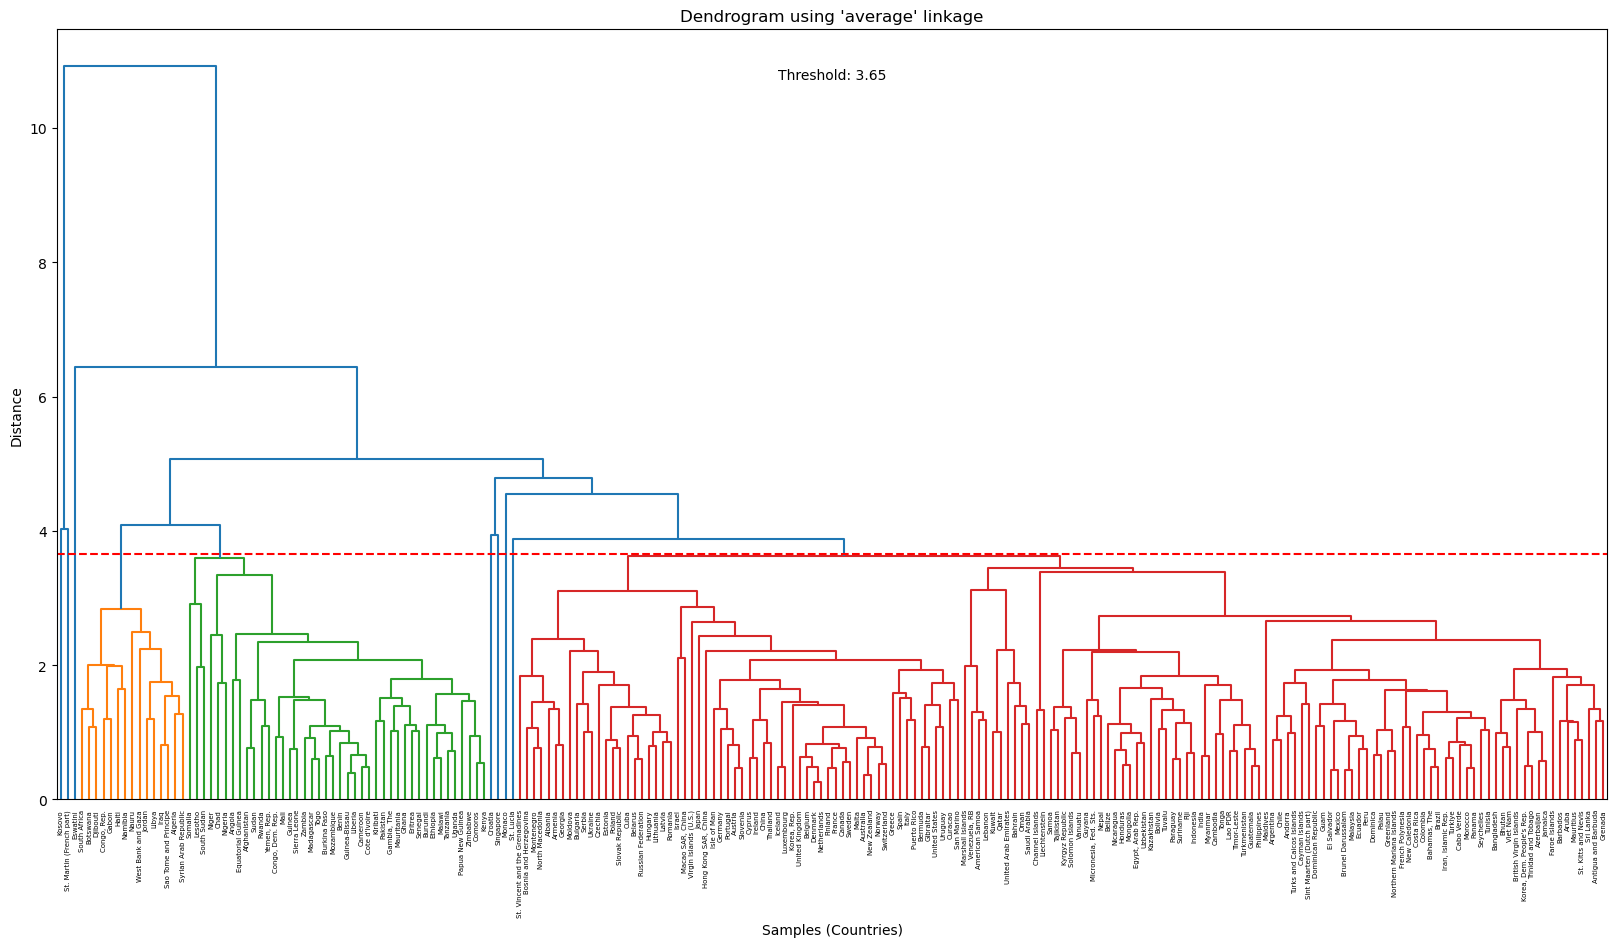

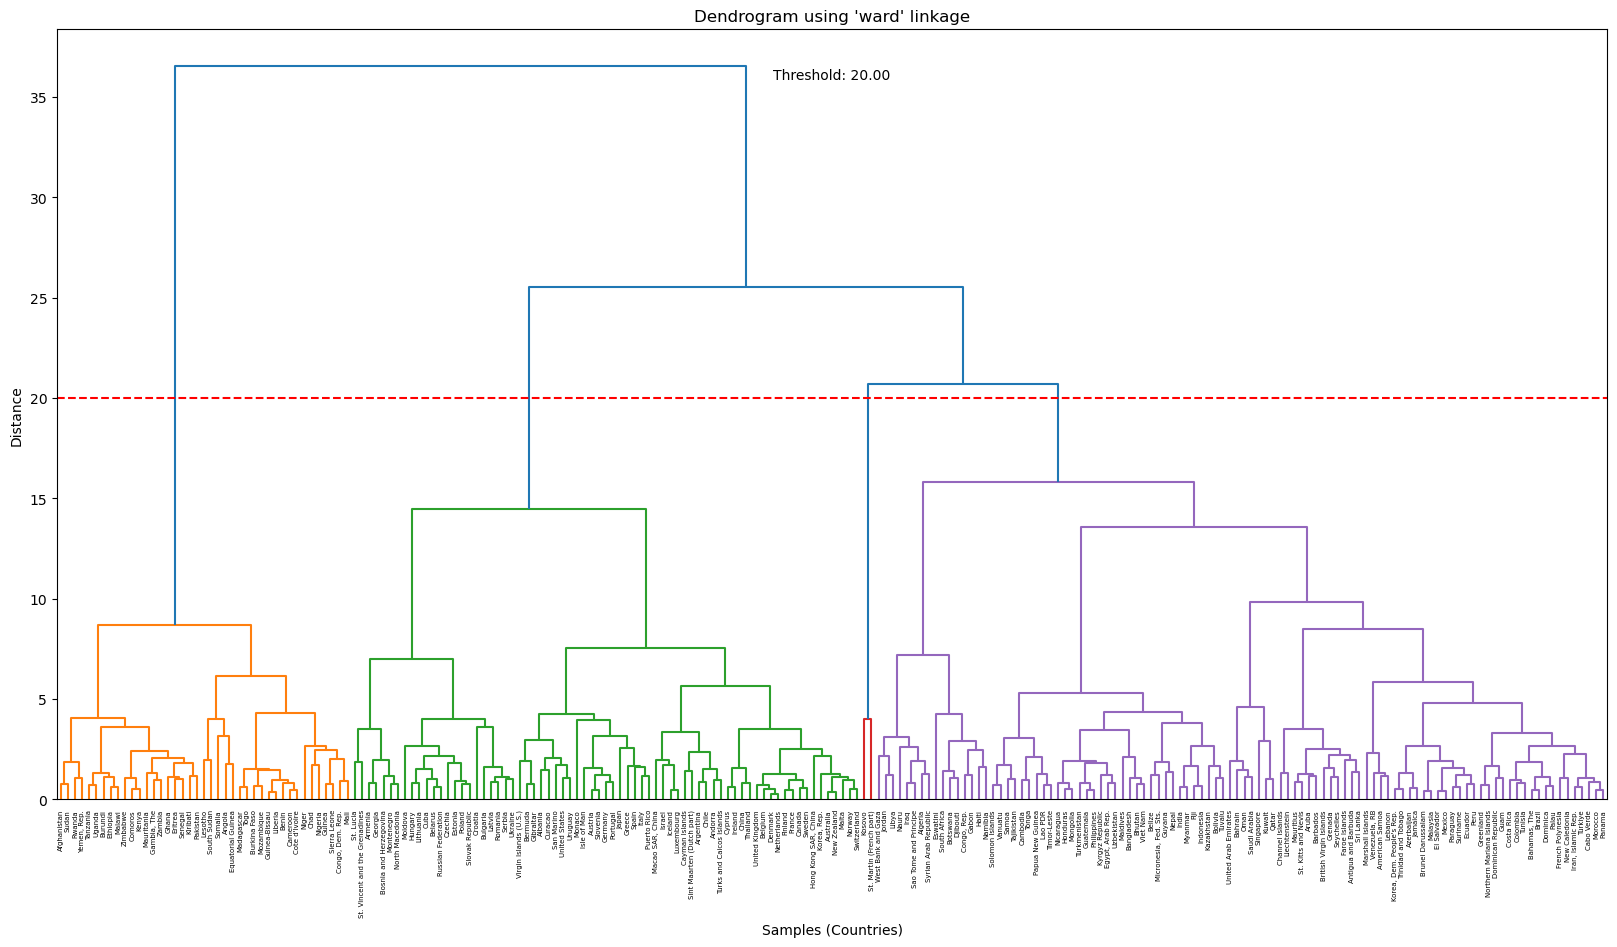

In [47]:
# try all linkage methods
linkage_methods = [('single', 2.1), ('complete', 7.35), ('average', 3.65), ('ward', 20)]

for method in linkage_methods:
    plot_dendrogram(df_scaled, method=method[0], color_threshold=method[1], country_names=countries)

From 4 algorithm for agglomerative clustering shows that 'complete' and 'ward' are the best case to aplly in model

In [48]:
# get linkage method with best threshold
best_linkage_methods = [('complete', 7.35), ('ward', 20)]

## Apply to model

In [49]:
# apply agglomerative clustering
df_result = pd.DataFrame({'Country Name': countries})
df_result.loc[:, selected_features] = df_selected_features

for method in best_linkage_methods:
    labels = do_agglomerative_clustering(df_scaled, linkage=method[0], distance_threshold=method[1])
    
    df_result.loc[:, f'Cluster {method[0]}'] = labels

    print(f"Agglomerative Clustering with '{method[0]}' linkage:")
    print(df_result[f'Cluster {method[0]}'].value_counts())
    print()

Agglomerative Clustering with 'complete' linkage:
Cluster complete
0    112
2     90
1      7
3      5
4      2
Name: count, dtype: int64

Agglomerative Clustering with 'ward' linkage:
Cluster ward
0    102
2     71
1     41
3      2
Name: count, dtype: int64



In [50]:
# show df_result
df_result

Country Name  Urban population (% of total population)  \
0              Afghanistan                                     26.31   
1                  Albania                                     62.97   
2                  Algeria                                     74.26   
3           American Samoa                                     87.17   
4                  Andorra                                     87.86   
..                     ...                                       ...   
211  Virgin Islands (U.S.)                                     96.04   
212     West Bank and Gaza                                     77.00   
213            Yemen, Rep.                                     38.55   
214                 Zambia                                     45.19   
215               Zimbabwe                                     32.30   

     Population growth (annual %)  \
0                            2.85   
1                           -0.93   
2                            1.66   
3                           -2.53   
4                            1.70   
..                            ...   
211                         -0.40   
212                          2.46   
213                          2.14   
214                          2.84   
215                          2.05   

     Population ages 0-14 (% of total population)  \
0                                           43.42   
1                                           16.28   
2                                           30.71   
3                                           27.51   
4                                           13.07   
..                                            ...   
211                                         19.24   
212                                         39.14   
213                                         39.87   
214                                         43.26   
215                                         40.89   

     Population ages 65 and above (% of total population)  \
0                                                 2.40      
1                                                16.23      
2                                                 6.18      
3                                                 6.84      
4                                                14.54      
..                                                 ...      
211                                              20.00      
212                                               3.48      
213                                               2.69      
214                                               1.74      
215                                               3.36      

     School enrollment, tertiary (% gross)  \
0                                24.454886   
1                                59.970000   
2                                54.210000   
3                                43.006242   
4                                15.200000   
..                                     ...   
211                              44.409221   
212                              43.510000   
213                              55.384619   
214                              29.281854   
215                              33.019135   

     Mortality rate, under-5 (per 1,000 live births)  \
0                                              59.60   
1                                               9.50   
2                                              22.30   
3                                              13.76   
4                                               2.80   
..                                               ...   
211                                            49.04   
212                                            14.80   
213                                            44.60   
214                                            57.20   
215                                            49.10   

     Life expectancy at birth, total (years)  \
0                                  61.980000   
1           

# Evaluation

## Silhouette score

In [51]:
# evaluate the clustering with silhouette score
silhouette_complete = silhouette_score(df_scaled, df_result['Cluster complete'])
silhouette_ward = silhouette_score(df_scaled, df_result['Cluster ward'])
print(f"Silhouette Score for 'complete' linkage: {silhouette_complete:.4f}")
print(f"Silhouette Score for 'ward' linkage: {silhouette_ward:.4f}")

Silhouette Score for 'complete' linkage: 0.2330
Silhouette Score for 'ward' linkage: 0.2570


## Davies-Bouldin Score

In [52]:
# evaluate the clustering with davies bouldin score
davies_complete = davies_bouldin_score(df_scaled, df_result['Cluster complete'])
davies_ward = davies_bouldin_score(df_scaled, df_result['Cluster ward'])
print(f"Davies-Bouldin Score for 'complete' linkage: {davies_complete:.4f}")
print(f"Davies-Bouldin Score for 'ward' linkage: {davies_ward:.4f}")

Davies-Bouldin Score for 'complete' linkage: 0.9821
Davies-Bouldin Score for 'ward' linkage: 1.0632
